### Typhoid Drug Reccommendation Pipeline (TyphoidRx)

### Imports

In [6]:
# === TYHOID ML PIPELINE WITH SYNTHETIC ROW ENGINEERING ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import joblib
import warnings
import random
import os
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import (
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from umap import UMAP
from matplotlib_venn import venn3
from itertools import combinations
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import time
import shap
from joblib import load
import psutil
from collections import defaultdict
import matplotlib.image as mpimg
from io import BytesIO
from PIL import Image
import argparse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
from sklearn.model_selection import (
    StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
)

In [7]:
# Create output directory
output_folder = "outputs/data_features_nature"
os.makedirs(output_folder, exist_ok=True)

# Step 1: Load and Inspect the Dataset
print("📥 Step 1: Loading dataset...")
df = pd.read_csv("Typhoid_Data.csv")
print(df.head())
print(df.info())
print("✅ Dataset loaded.")

# Step 2: Handle Missing Data
print("\n🔍 Step 2: Checking missing data...")
missing = df.isnull().sum()
print("Missing values per column:")
print(missing)

# Save missing values report
missing.to_csv(os.path.join(output_folder, "missing_report.csv"), header=True)
print("📄 Missing values report saved as missing_report.csv")

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)

# 🛠️ Clean 'Treatment Duration' (remove 'days' and convert to float)
df['Treatment Duration'] = (
    df['Treatment Duration']
    .astype(str)
    .str.replace('days', '', case=False, regex=False)
    .str.strip()
    .replace('Unknown', np.nan)  # in case 'Unknown' is still present
    .astype(float)
)

# 🧼 Fill missing 'Treatment Duration' with median
df['Treatment Duration'].fillna(df['Treatment Duration'].median(), inplace=True)

print("✅ Missing values handled. Output: cleaned_dataset.csv")

# Encode Gender and Treatment Outcome after handling missing values
df['Gender'] = df['Gender'].astype(str).str.strip().str.lower().map(
    lambda x: 1 if x in ['male', 'm', '1'] else (0 if x in ['female', 'f', '0'] else np.nan)
)

df['Treatment Outcome'] = df['Treatment Outcome'].astype(str).str.strip().str.lower().map(
    lambda x: 1 if x in ['successful', '1'] else (0 if x in ['unsuccessful', '0'] else np.nan)
)

df.dropna(subset=['Gender', 'Treatment Outcome'], inplace=True)

df.to_csv("cleaned_dataset.csv", index=False)

# Confirm file saved
if os.path.exists("cleaned_dataset.csv"):
    print("✅ File saved successfully.")
    print("✅ Rows, Columns:", pd.read_csv("cleaned_dataset.csv").shape)

# Step 3: Class Distribution
print("\n📊 Step 3: Class distribution")
class_distribution = df['Treatment Outcome'].value_counts()
print(class_distribution)

# Save class distribution
class_distribution.to_csv(os.path.join(output_folder, "class_distribution.csv"), header=True)
print("📄 Class distribution saved as class_distribution.csv")

# Plot and save Treatment Outcome distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Treatment Outcome', data=df, palette='Set2')
plt.title('Treatment Outcome Distribution')
plt.xlabel('Treatment Outcome')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "treatment_outcome_distribution.png"))
plt.close()
print("🖼️ Treatment Outcome distribution saved as treatment_outcome_distribution.png")

# Step 4: Basic Statistics
print("\n📈 Step 4: Descriptive Statistics")
desc_stats = df.describe()
print(desc_stats)

# Step 4: Combined Descriptive Statistics (for both numeric and categorical data)
print("\n📈 Step 4: Full Descriptive Statistics (numeric + categorical)")

# Get descriptive statistics including all columns
full_desc_stats = df.describe(include='all')

# Save descriptive statistics to CSV
full_desc_stats.to_csv(os.path.join(output_folder, "descriptive_statistics_full.csv"))
print("📄 Full descriptive statistics saved as descriptive_statistics_full.csv")

# Display preview
print(full_desc_stats)

from matplotlib.backends.backend_pdf import PdfPages

print("\n📊 Step 5: Visualizing distributions...")

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Focus on special categorical vars to include in grid
key_categorical_cols = [
    'Blood Culture Bacteria',
    'Urine Culture Bacteria',
    'Symptoms Severity',
    'Current Medication'
]
# Filter only those present in dataset
key_categorical_cols = [col for col in key_categorical_cols if col in df.columns]

# === Create one combined PDF ===
combined_pdf_path = os.path.join(output_folder, "all_distributions_combined.pdf")
with PdfPages(combined_pdf_path) as pdf:

    # === Page 1: Numeric Histograms Grid ===
    num_plots = len(numeric_cols)
    ncols = 3
    nrows = int(np.ceil(num_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 3.5))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        axes[i].hist(df[col].dropna(), bins=20, color='steelblue')
        axes[i].set_title(col)
        axes[i].set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    print("✅ Numeric histograms plotted and added to PDF.")

    # === Page 2: Categorical Grid ===
    if key_categorical_cols:
        ncols = 2
        nrows = int(np.ceil(len(key_categorical_cols) / ncols))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
        axes = axes.flatten()

        for i, col in enumerate(key_categorical_cols):
            sns.countplot(data=df, x=col, ax=axes[i], palette='Set2')
            axes[i].set_title(f"{col} Distribution")
            axes[i].tick_params(axis='x', rotation=45)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close()
        print("✅ Categorical bar plots added to PDF.")

print(f"📄 All distributions saved to: {combined_pdf_path}")
# === Restore Correlation Heatmap ===
print("📊 Plotting correlation heatmap...")

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    df.select_dtypes(include='number').corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    annot_kws={"size": 9}
)
plt.title("Correlation Heatmap")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "correlation_heatmap.png"), dpi=600)
plt.close()

print("✅ Correlation heatmap saved as correlation_heatmap.png")



📥 Step 1: Loading dataset...
   Patient ID  Age  Gender Symptoms Severity  Hemoglobin (g/dL)  \
0           1   38  Female               Low          24.012919   
1           2   48    Male          Moderate          12.300000   
2           3   33    Male              High          10.700000   
3           4   56    Male              High          14.900000   
4           5   67    Male               NaN          13.100000   

   Platelet Count Blood Culture Bacteria Urine Culture Bacteria  \
0          259366       Escherichia coli  Klebsiella pneumoniae   
1          208128       Salmonella typhi                      -   
2          251028       Escherichia coli                      -   
3          157787       Salmonella typhi  Klebsiella pneumoniae   
4          217075       Salmonella typhi       Escherichia coli   

   Calcium (mg/dL)  Potassium (mmol/L) Current Medication Treatment Duration  \
0              8.7            9.079248        Amoxicillin            15 days   
1    

In [8]:
os.makedirs("processed", exist_ok=True)
os.makedirs("intermediate_data", exist_ok=True)

# ----------------------------------------------------------------------
# 0. CONSTANTS
# ----------------------------------------------------------------------
MED_COLS = ['Medication_Amoxicillin', 'Medication_Azithromycin', 'Medication_Ceftriaxone']
TARGET_COLS = ['Resistance_Proxy_Score ', 'Suspected_Typhoid']
OUTCOME_TGT = 'Treatment Outcome'
DURATION_TGT = 'Treatment Duration'

# ----------------------------------------------------------------------
# 1. LOAD DATA
# ----------------------------------------------------------------------
df = pd.read_csv("cleaned_dataset.csv")
df = df.drop_duplicates(subset="Patient ID", keep="first").reset_index(drop=True)
#df.drop(columns=[c for c in LEAKAGE_COLS if c in df.columns], inplace=True)
df.dropna(subset=[OUTCOME_TGT, DURATION_TGT], inplace=True)

# Bacteria encoding
all_bact = pd.concat([
    df['Blood Culture Bacteria'].fillna('None'),
    df['Urine Culture Bacteria'].fillna('None')
])
bact_enc = LabelEncoder().fit(all_bact)
df['Blood_Culture_Bacteria_Encoded'] = bact_enc.transform(df['Blood Culture Bacteria'].fillna('None'))
df['Urine_Culture_Bacteria_Encoded'] = bact_enc.transform(df['Urine Culture Bacteria'].fillna('None'))


In [9]:
# ----------------------------------------------------------------------
# 3. OPTIONAL SYNTHETIC DATA AUGMENTATION (CLEANED & STRICTLY DEFINED)
# ----------------------------------------------------------------------

core_features = [
    'Patient ID', 'Age', 'Gender', 'Symptoms Severity',
    'Hemoglobin (g/dL)', 'Platelet Count',
    'Blood Culture Bacteria', 'Urine Culture Bacteria',
    'Calcium (mg/dL)', 'Potassium (mmol/L)',
    'Treatment Duration', 'Treatment Outcome',
    'Current Medication'  # ✅ add this
]
# Extract only the core training rows
X_tr_core = df[core_features].copy()

def generate_synthetic_rows_strict(df, n_samples):
    # Separate numeric and categorical
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    df_categorical = df.select_dtypes(exclude=[np.number]).copy()

    # Remove categorical-like numeric columns from interpolation (e.g., encoded bacteria)
    drop_cols = ['Blood Culture Bacteria', 'Urine Culture Bacteria']
    drop_cols = [col for col in drop_cols if col in df_numeric.columns]
    df_numeric_interp = df_numeric.drop(columns=drop_cols, errors='ignore')

    # Fit Nearest Neighbors for interpolation
    neighbors = NearestNeighbors(n_neighbors=5).fit(df_numeric_interp)
    indices = np.random.choice(df_numeric_interp.shape[0], n_samples)
    std_devs = df_numeric_interp.std()
    
    synth_rows = []
    for idx in indices:
        row = df_numeric_interp.iloc[idx]
        _, neighbor_ids = neighbors.kneighbors([row])
        # Randomly select one of the nearest neighbors (excluding self)
        neighbor_idx = np.random.choice(neighbor_ids[0][1:])
        neighbor = df_numeric_interp.iloc[neighbor_idx]
        noise = np.random.normal(0, std_devs * 0.02)  # Scale noise by std deviation
        new_row = row + (neighbor - row) * 0.5 + noise
        new_row = np.clip(new_row, 0, None)
        synth_rows.append(new_row)

    df_synth_num = pd.DataFrame(synth_rows, columns=df_numeric_interp.columns)

    # Restore dropped numeric categorical columns from sampling
    for col in drop_cols:
        df_synth_num[col] = df[col].dropna().sample(n=n_samples, replace=True, random_state=SEED).values

    # Generate synthetic Patient IDs
    if 'Patient ID' in df_synth_num.columns:
        max_id = int(df_numeric['Patient ID'].max())
        df_synth_num['Patient ID'] = range(max_id + 1, max_id + 1 + n_samples)

    # Coerce Gender
    # ✅ Coerce Gender to strictly 0 or 1 — fixed and safe
    if 'Gender' in df_synth_num.columns:
        df_synth_num['Gender'] = pd.to_numeric(df_synth_num['Gender'], errors='coerce') \
                                .round().clip(0, 1).astype(int)

    # Recombine with categorical columns (other than bacteria)
    cat_cols = [col for col in df_categorical.columns if col not in drop_cols]
    df_synth_cat = df_categorical[cat_cols].sample(n=n_samples, replace=True, random_state=SEED).reset_index(drop=True)
    df_synth_num.reset_index(drop=True, inplace=True)
    df_synth_combined = pd.concat([df_synth_num, df_synth_cat], axis=1)

    # Add synthesis metadata
    df_synth_combined["Synthetic_ID"] = [f"SYN_{i}" for i in range(1, n_samples + 1)]
    df_synth_combined["Synthesis_Method"] = "NN-Interp"

    return df_synth_combined

# Generate synthetic data
# === SPLIT DATA FOR AUGMENTATION & EVALUATION ===
train_df, test_df = train_test_split(X_tr_core, test_size=0.25, random_state=SEED, stratify=X_tr_core['Treatment Outcome'])

# Save the outcome test target for evaluation
y_outcome_te = test_df["Treatment Outcome"].copy()
joblib.dump(y_outcome_te, "intermediate_data/y_outcome_te.joblib")

# Optionally, save the raw test set too if needed later
joblib.dump(test_df, "intermediate_data/raw_test_df.joblib")

# Save original training set for augmentation
original_train_df = train_df.copy()

# Optionally save test set separately if you’ll evaluate later
test_df.to_csv("intermediate_data/test_set_for_evaluation.csv", index=False)

original_train_df = train_df.copy()
#synthetic_df = generate_synthetic_rows_strict(original_train_df, len(original_train_df) * 2)
synthetic_df = pd.DataFrame(columns=original_train_df.columns)
# ✅ Coerce Gender to strictly 0 (Female) or 1 (Male)
if not synthetic_df.empty and 'Gender' in synthetic_df.columns:
    synthetic_df['Gender'] = synthetic_df['Gender'].apply(lambda x: 1 if str(x).strip().lower() in ['1', 'male', 'm'] else 0)

# Combine with original training set

original_train_df["Source"] = "Original"
synthetic_df["Source"] = "Synthetic"
# 🔧 Replace synthetic Treatment Outcome with valid binary values (stratified sampling)
if 'Treatment Outcome' in synthetic_df.columns:
    real_outcomes = original_train_df['Treatment Outcome']
    outcome_probs = real_outcomes.value_counts(normalize=True).to_dict()
    synthetic_df['Treatment Outcome'] = np.random.choice(
        [0, 1],
        size=len(synthetic_df),
        replace=True,
        p=[outcome_probs.get(0, 0.5), outcome_probs.get(1, 0.5)]
    )



os.makedirs("intermediate_data", exist_ok=True)

# === STRICTLY PLOT ONLY THE 12 SYNTHESIZED FEATURES (no status or engineered)
features_to_plot = [
    'Patient ID', 'Age', 'Gender', 'Symptoms Severity',
    'Hemoglobin (g/dL)', 'Platelet Count',
    'Blood Culture Bacteria', 'Urine Culture Bacteria',
    'Calcium (mg/dL)', 'Potassium (mmol/L)',
    'Treatment Duration', 'Treatment Outcome'
]

categorical_features = [
    'Symptoms Severity', 'Blood Culture Bacteria', 'Urine Culture Bacteria', 'Gender'
]

# Add a column to each dataset to indicate source
original_train_df["Source"] = "Original"
synthetic_df["Source"] = "Synthetic"

# Combine both for plotting
plot_df = pd.concat([
    original_train_df[features_to_plot + ["Source"]],
    synthetic_df[features_to_plot + ["Source"]]
], axis=0).reset_index(drop=True)

# Ensure Treatment Duration is numeric (e.g., extract from "5 days")
plot_df['Treatment Duration'] = plot_df['Treatment Duration'].astype(str).str.extract(r'(\d+)').astype(float)
plot_df["Gender"] = plot_df["Gender"].astype(int)

# === Individual plots
for col in features_to_plot:
    plt.figure(figsize=(6, 4))
    try:
        if col in categorical_features:
            sns.countplot(data=plot_df, x=col, hue="Source")
        else:
            sns.kdeplot(data=plot_df, x=col, hue="Source", fill=True, common_norm=False, linewidth=2)
        plt.title(f"Distribution: {col}", fontsize=11)
        plt.tight_layout()
        fname = f"distplot_{col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '')}_overlay.png"
        plt.savefig(os.path.join("intermediate_data", fname), dpi=600)
        plt.close()
    except Exception as e:
        print(f"⚠️ Skipped {col} due to error: {e}")

# === Grid overlay plot: auto layout based on number of features
n = len(features_to_plot)
cols = 4
rows = -(-n // cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    try:
        if col in categorical_features:
            sns.countplot(data=plot_df, x=col, hue="Source", ax=axes[i])
        else:
            sns.kdeplot(data=plot_df, x=col, hue="Source", fill=True, common_norm=False, ax=axes[i], linewidth=2)
        axes[i].set_title(f"({chr(97 + i)}) {col}", fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error: {col}", ha='center')
        axes[i].set_title(f"({chr(97 + i)}) {col}")
        print(f"⚠️ Skipped {col} in grid due to error: {e}")

for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("intermediate_data/all_distributions_overlay_grid.png", dpi=600)
plt.close()
augmented_train_df = pd.concat([original_train_df, synthetic_df], axis=0).reset_index(drop=True)


In [10]:
# ----------------------------------------------------------------------
# 4. FEATURE ENGINEERING (Final Verified Version)
# ----------------------------------------------------------------------

# === RULE-BASED METABOLOMIC SIMULATION ===
def simulate_metabolomics_rule_based(df):
    df['SimMet_EnergyDisruption'] = np.where(
        ((df['Sex_Code'] == 1) & (df['Hemoglobin (g/dL)'] < 13.0)) |
        ((df['Sex_Code'] == 0) & (df['Hemoglobin (g/dL)'] < 12.0)),
        1, 0
    )
    df['SimMet_HypoxiaStress'] = df['SimMet_EnergyDisruption']

    df['SimMet_MembraneInstability'] = np.where(
        (df['Calcium (mg/dL)'] < 8.5) | (df['Calcium (mg/dL)'] > 10.5),
        1, 0
    )

    df['SimMet_ElectrolyteDisruption'] = np.where(
        (df['Potassium (mmol/L)'] < 3.5) | (df['Potassium (mmol/L)'] > 5.0),
        1, 0
    )

    df['SimMet_CatabolicBurst'] = np.where(
        (df.get('WBC', 0) > 11.0) | (df.get('Severity_Score', 0) >= 2),
        1, 0
    )

    df['SimMet_InflammatoryStress'] = np.where(
        df['Platelet Count'] > 450000,
        1, 0
    )
    return df

# === HEMOGLOBIN LOGIC ===
def classify_hemoglobin(row):
    hb = row['Hemoglobin (g/dL)']
    sex = row['Sex_Code']
    if sex == 1:
        return 1 if hb < 13.0 else 0
    elif sex == 0:
        return 1 if hb < 12.0 else 0
    else:
        return -1

# === MAIN FEATURE ENGINEERING FUNCTION ===
def engineer_features(df: pd.DataFrame, seed=42) -> pd.DataFrame:
    df = df.copy()

    severity_map = {'Low': 1, 'Moderate': 2, 'High': 3}
    df['Severity_Score'] = df['Symptoms Severity'].map(severity_map)

    df['Blood Culture Bacteria'] = df['Blood Culture Bacteria'].replace('-', np.nan).str.lower()
    df['Urine Culture Bacteria'] = df['Urine Culture Bacteria'].replace('-', np.nan).str.lower()
    df['Culture_Concordance'] = (df['Blood Culture Bacteria'] == df['Urine Culture Bacteria']).astype(int)

    df['Salmonella_Presence'] = df[['Blood Culture Bacteria', 'Urine Culture Bacteria']].apply(
        lambda row: 1 if 'salmonella typhi' in str(row[0]) or 'salmonella typhi' in str(row[1]) else 0, axis=1)

    def classify_culture_type(row):
        blood, urine = row['Blood Culture Bacteria'], row['Urine Culture Bacteria']
        if pd.isna(blood) and pd.isna(urine): return 0
        elif pd.notna(blood) and pd.isna(urine): return 1
        elif pd.isna(blood) and pd.notna(urine): return 2
        elif blood == urine: return 3
        else: return 4
    df['Culture_Type'] = df.apply(classify_culture_type, axis=1)

    df['Sex_Code'] = df['Gender'].astype(str).str.strip().str.lower().map(
        lambda x: 1 if x in ['1', 'male', 'm'] else (0 if x in ['0', 'female', 'f'] else -1))

    # ✅ Safe encoding only if column exists
    if 'Current Medication' in df.columns:
        df = pd.get_dummies(df, columns=['Current Medication'], prefix='Medication')

    for med in ['Medication_Amoxicillin', 'Medication_Azithromycin', 'Medication_Ceftriaxone']:
        if med not in df.columns:
            df[med] = 0

    df['Intensity_Score'] = df['Severity_Score'] ** 2
    df['Treatment Duration Clean'] = df['Treatment Duration'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float)
    df['Normalized_Duration'] = df['Treatment Duration Clean'] / (df['Severity_Score'] + 1e-6)

    df['Resistance_Proxy_Score'] = (
        (1 - df['Culture_Concordance']) * df['Normalized_Duration'] * df['Severity_Score']
    )

    df['Hemoglobin_Status'] = df.apply(classify_hemoglobin, axis=1)
    df['Platelet_Status'] = df['Platelet Count'].apply(lambda x: 1 if x < 150000 else (2 if x > 450000 else 0))
    df['Calcium_Status'] = df['Calcium (mg/dL)'].apply(lambda x: 1 if x < 8.5 else (2 if x > 10.2 else 0))
    df['Potassium_Status'] = df['Potassium (mmol/L)'].apply(lambda x: 1 if x < 3.5 else (2 if x > 5.0 else 0))

    df['Suspected_Typhoid'] = np.where(
        (df['Salmonella_Presence'] == 1) |
        ((df['Severity_Score'] >= 2) &
         ((df['Hemoglobin_Status'] == 1) | (df['Platelet_Status'] == 1))),
        1, 0
    )

    df = simulate_metabolomics_rule_based(df)

    metabolomic_features = [
        'Hemoglobin (g/dL)', 'Platelet Count', 'Calcium (mg/dL)', 'Potassium (mmol/L)',
        'SimMet_EnergyDisruption', 'SimMet_InflammatoryStress', 'SimMet_MembraneInstability',
        'SimMet_ElectrolyteDisruption', 'SimMet_CatabolicBurst', 'SimMet_HypoxiaStress'
    ]
    metabo_data = df[metabolomic_features].copy()
    metabo_data.fillna(metabo_data.median(), inplace=True)
    X_scaled = StandardScaler().fit_transform(metabo_data)
    X_pca = PCA(n_components=2).fit_transform(X_scaled)
    df[['PC1', 'PC2']] = X_pca

    return df.reset_index(drop=True)

augmented_train_df = engineer_features(augmented_train_df)
augmented_train_df.to_csv("intermediate_data/augmented_engineered_training_data.csv", index=False)
# === Scatter plot of PC1 vs PC2 ===
scatter_dir = "intermediate_data"
os.makedirs(scatter_dir, exist_ok=True)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=augmented_train_df,
    x="PC1", y="PC2",
    hue="Suspected_Typhoid",  # Optional: use another label
    palette="coolwarm", alpha=0.7, edgecolor='k'
)
plt.title("Simulated Metabolomics PCA: PC1 vs PC2")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title="Suspected Typhoid", loc='best')
plt.tight_layout()

scatter_path = os.path.join(scatter_dir, "metabolomics_pc1_vs_pc2_scatter.png")
plt.savefig(scatter_path, dpi=600, format='png')
plt.close()
print(f"✅ PCA scatter plot saved to: {scatter_path}")

test_engineered = engineer_features(test_df.copy())
test_engineered.to_csv("intermediate_data/test_data.csv", index=False)

# === Define targets ===
yty_te = test_engineered['Suspected_Typhoid'].astype(int)
ydur_te = test_engineered['Treatment Duration Clean']
yres_te = test_engineered['Resistance_Proxy_Score']

# === Duration model X_te ===
# Modified version without dropping MED_COLS
X_te_duration = (
    test_engineered
    .drop(columns=[col for col in ['Normalized_Duration', 'Resistance_Proxy_Score', 'Treatment Duration', 'Treatment Duration Clean', 'Patient ID',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status', 'PC1', 'PC2'] if col in test_engineered.columns])
    .select_dtypes(include=[np.number, 'bool'])
)

joblib.dump(X_te_duration, "intermediate_data/X_te_duration.joblib")

# === Resistance model X_te ===
# Modified version without dropping MED_COLS
X_te_resistance = (
    test_engineered
    .drop(columns=[col for col in [    'Normalized_Duration', 'Resistance_Proxy_Score', 'Treatment Duration',
    'Treatment Duration Clean', 'Patient ID', 'Culture_Concordance', 'Severity_Score',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status',
    'PC1', 'PC2'] if col in test_engineered.columns])
    .select_dtypes(include=[np.number, 'bool'])
)

joblib.dump(X_te_resistance, "intermediate_data/X_te_resistance.joblib")

# === Typhoid suspected model X_te ===
X_te_typhoid = (
    test_engineered
    .drop(columns=[col for col in MED_COLS + [    'Salmonella_Presence', 'Suspected_Typhoid', 'Patient ID',
    'Treatment Duration', 'Intensity_Score',
    'Hemoglobin_Status', 'Potassium_Status',
    'PC1', 'PC2', 'Calcium_Status'] if col in test_engineered.columns])
    .select_dtypes(include=[np.number, 'bool'])
)
joblib.dump(X_te_typhoid, "intermediate_data/X_te_typhoid.joblib")

original_only_df = augmented_train_df[augmented_train_df["Source"] == "Original"].copy()

# === Outcome model X_te ===
X_te_outcome = (
    test_engineered
    .drop(columns=[        'Treatment Outcome', 'Treatment Duration', 'Patient ID',
        'Resistance_Proxy_Score', 'Normalized_Duration', 'Treatment Duration Clean',
        'Hemoglobin_Status', 'Potassium_Status', 'Intensity_Score',
        'PC1', 'PC2', 'Calcium_Status'], errors='ignore')
    .select_dtypes(include=[np.number, 'bool'])
)
joblib.dump(X_te_outcome, "intermediate_data/X_te_outcome.joblib")

# === Save targets + raw df ===
joblib.dump(yty_te, "intermediate_data/yty_te.joblib")
joblib.dump(ydur_te, "intermediate_data/ydur_te.joblib")
joblib.dump(yres_te, "intermediate_data/yres_te.joblib")
joblib.dump(test_df, "intermediate_data/raw_test_df.joblib")

print("✅ X_te sets and targets saved successfully.")
# ========== DISTRIBUTION PLOTS FOR ENGINEERED FEATURES ONLY ========== #

engineered_features = [
    'Severity_Score', 'Culture_Concordance', 'Salmonella_Presence', 'Culture_Type',
    'Sex_Code', 'Medication_Amoxicillin', 'Medication_Azithromycin', 'Medication_Ceftriaxone',
    'Intensity_Score', 'Treatment Duration Clean', 'Normalized_Duration', 'Resistance_Proxy_Score',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status', 'Suspected_Typhoid',
    'SimMet_EnergyDisruption', 'SimMet_HypoxiaStress', 'SimMet_MembraneInstability',
    'SimMet_ElectrolyteDisruption', 'SimMet_CatabolicBurst', 'SimMet_InflammatoryStress',
    'PC1', 'PC2'
]

plot_dir = "intermediate_data/engineered_feature_plots"
os.makedirs(plot_dir, exist_ok=True)

n = len(engineered_features)
cols = 4
rows = -(-n // cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(engineered_features):
    try:
        if augmented_train_df[col].nunique() < 10:
            sns.countplot(data=augmented_train_df, x=col, ax=axes[i])
        else:
            sns.kdeplot(data=augmented_train_df, x=col, fill=True, ax=axes[i], linewidth=2)
        axes[i].set_title(f"({chr(97 + i)}) {col}", fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error: {col}", ha='center')
        axes[i].set_title(f"({chr(97 + i)}) {col}")
        print(f"⚠️ Skipped {col} due to error: {e}")

for j in range(len(engineered_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "engineered_features_distribution_grid.png"), dpi=600)
plt.close()


✅ PCA scatter plot saved to: intermediate_data\metabolomics_pc1_vs_pc2_scatter.png
✅ X_te sets and targets saved successfully.


In [11]:
# ----------------------------------------------------------------------
# 4b. SAFE OUTCOME MODEL TRAINING (Original + Engineered, No Leakage)
# ----------------------------------------------------------------------

print("\n🔍 Training Outcome Model (Original Data + Engineered, No Leakage, Safe SMOTE)...")

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# -----------------------------
# 1. TARGET
# -----------------------------
outcome_y = augmented_train_df['Treatment Outcome']

# Fix numeric conversion
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')

# -----------------------------
# 2. FEATURE SELECTION
# -----------------------------
outcome_X = (
    augmented_train_df
    .drop(columns=[
        'Treatment Outcome', 'Treatment Duration', 'Patient ID',
        'Resistance_Proxy_Score', 'Normalized_Duration', 'Treatment Duration Clean',
        'Hemoglobin_Status', 'Potassium_Status', 'Intensity_Score',
        'PC1', 'PC2', 'Calcium_Status'
    ], errors='ignore')
    .select_dtypes(include=[np.number, 'bool'])
)

# -----------------------------
# 3. DROP ALL-NaN COLUMNS
# -----------------------------
nan_columns = outcome_X.columns[outcome_X.isnull().all()]
if len(nan_columns) > 0:
    print("⚠️ Columns with all NaNs (dropping):", list(nan_columns))
    outcome_X.drop(columns=nan_columns, inplace=True)
else:
    print("✅ No columns with all missing values.")

# -----------------------------
# 4. DROP ROWS WITH ANY NaNs
# -----------------------------
valid_rows = outcome_X.notnull().all(axis=1) & outcome_y.notnull()

# Save dropped rows
os.makedirs("diagnostics", exist_ok=True)
outcome_X[~valid_rows].assign(Target=outcome_y[~valid_rows]).to_csv(
    "diagnostics/dropped_outcome_rows_with_nans.csv", index=False
)

print(f"📏 Rows before dropping NaNs: {outcome_X.shape[0]}")
print(f"📉 Dropped rows: {(~valid_rows).sum()}")

outcome_X = outcome_X[valid_rows]
outcome_y = outcome_y[valid_rows]

print(f"📏 Rows after dropping NaNs: {outcome_X.shape[0]}")

# -----------------------------
# 5. CORRELATION CHECK
# -----------------------------
print("\n🔬 Checking highly correlated feature pairs (Outcome Model)...")

corr_matrix = outcome_X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.9]

print("\n🔍 Highly Correlated Feature Pairs in Outcome Model:")
print(high_corr_pairs)

# -----------------------------
# 6. CLASS DISTRIBUTION
# -----------------------------
print(f"Original outcome class distribution: {Counter(outcome_y)}")

# -----------------------------
# 7. SAFE SMOTE + XGBoost Pipeline
# -----------------------------

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=SEED)),
    ('clf', XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=SEED
    ))
])

# All XGB parameters MUST be prefixed with 'clf__'
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 4, 5, 6, 8],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 1, 3, 5],
    'clf__reg_lambda': [0.1, 1, 10]
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv_strategy,
    verbose=1,
    random_state=SEED
)

# -----------------------------
# 8. TRAIN WITH SAFE CV + SMOTE
# -----------------------------
search.fit(outcome_X, outcome_y)

print("\n📝 Features used in final model:")
print(list(outcome_X.columns))

print("\n📊 Data types of features:")
print(outcome_X.dtypes.value_counts())

print("\n🏁 Best CV ROC AUC score:")
print(search.best_score_)

print("\n✅ Outcome Model (Trained safely with SMOTE and engineered features):")
print(search.best_params_)

# -----------------------------
# 9. SAVE MODELS + FEATURES
# -----------------------------
best_model = search.best_estimator_
joblib.dump(best_model, "xgb_model_outcome.pkl")

# Save bacterial encoder if needed
joblib.dump(bact_enc, "label_encoder_bacteria.pkl")

feat_outcome = list(outcome_X.columns)
joblib.dump(feat_outcome, "X_features_outcome.joblib")

# Save X with IDs for pipeline
augmented_train_df[['Patient ID']].join(outcome_X).to_csv(
    "processed/X_train_outcome_pipeline.csv",
    index=False
)



🔍 Training Outcome Model (Original Data + Engineered, No Leakage, Safe SMOTE)...
✅ No columns with all missing values.
📏 Rows before dropping NaNs: 3888
📉 Dropped rows: 408
📏 Rows after dropping NaNs: 3480

🔬 Checking highly correlated feature pairs (Outcome Model)...

🔍 Highly Correlated Feature Pairs in Outcome Model:
                 Feature 1                     Feature 2  Correlation
0  SimMet_EnergyDisruption          SimMet_HypoxiaStress     1.000000
1       Potassium (mmol/L)  SimMet_ElectrolyteDisruption     0.906015
Original outcome class distribution: Counter({1.0: 1895, 0.0: 1585})
Fitting 5 folds for each of 30 candidates, totalling 150 fits

📝 Features used in final model:
['Age', 'Hemoglobin (g/dL)', 'Platelet Count', 'Calcium (mg/dL)', 'Potassium (mmol/L)', 'Severity_Score', 'Culture_Concordance', 'Salmonella_Presence', 'Culture_Type', 'Sex_Code', 'Medication_Amoxicillin', 'Medication_Azithromycin', 'Medication_Ceftriaxone', 'Platelet_Status', 'Suspected_Typhoid', 'Sim

In [12]:
# ----------------------------------------------------------------------
# 5. FINAL MODEL TRAINING
# ----------------------------------------------------------------------
#Treatment Duration
print("\n🔍 Training Treatment Duration Model (Augmented Data)...")

# Augmented features
X_aug = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()

# Drop medication columns and duration-related leaks
# Drop medication columns, duration-related leaks, and multicollinear features
drop_cols = [
    'Normalized_Duration', 'Resistance_Proxy_Score', 'Treatment Duration',
    'Treatment Duration Clean', 'Patient ID',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status',
    'PC1', 'PC2'
]

# Convert to numeric and coerce errors
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')
X_aug.drop(columns=[col for col in drop_cols if col in X_aug.columns], inplace=True)

# Optional: Check VIFs to ensure multicollinearity is handled

# Copy and convert boolean to int
X_vif = X_aug.copy()
bool_cols = X_vif.select_dtypes(include='bool').columns
X_vif[bool_cols] = X_vif[bool_cols].astype(int)

# Drop or replace any NaNs / infs
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
X_vif = X_vif.dropna()

# Add constant for intercept
X_const = add_constant(X_vif)

# Compute VIF safely
vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i + 1) for i in range(X_vif.shape[1])]
print("\n📌 VIF after dropping multicollinear features:")
print(vif_df.sort_values("VIF", ascending=False))

# Target
ydur_aug = augmented_train_df['Treatment Duration Clean']

# CV & hyperparam grid
cv_reg = KFold(n_splits=5, shuffle=True, random_state=SEED)
reg_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 3],
    'reg_lambda': [0.1, 1, 10]
}

# Model search
search_dur = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=SEED),
    param_distributions=reg_param_grid,
    n_iter=30,
    scoring='r2',
    n_jobs=-1,
    cv=cv_reg,
    verbose=1,
    random_state=SEED
)
search_dur.fit(X_aug, ydur_aug)

# Diagnostic prints
print("\n📝 Features used in final model:")
print(list(X_aug.columns))

print("\n📊 Data types of features:")
print(X_aug.dtypes.value_counts())

print("\n🏁 Best CV R2 score:")
print(search_dur.best_score_)

print("\n✅ Treatment Duration Model (Re-trained safely with engineered features):")
print(search_dur.best_params_)

# Save model
joblib.dump(search_dur.best_estimator_, "xgb_model_duration.pkl")
# Save the actual features used (after dropping leaks)
feat_duration = list(X_aug.columns)  # X_aug for duration
joblib.dump(feat_duration, "X_features_duration.joblib")

# Save X with ID for future use
# Save X with ID for future use — use augmented data's IDs
augmented_train_df[['Patient ID']].join(X_aug).to_csv("processed/X_train_duration_pipeline.csv", index=False)

#Resistace Proxy Score
print("\n🔍 Training Resistance Proxy Model (Augmented Data)...")

# Select only numeric or boolean features
X_aug = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()

# Drop medication columns, duration leaks, and ID
drop_cols = [
    'Normalized_Duration', 'Resistance_Proxy_Score', 'Treatment Duration',
    'Treatment Duration Clean', 'Patient ID', 'Culture_Concordance', 'Severity_Score',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status',
    'PC1', 'PC2'
]

# Convert to numeric and coerce errors
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')
X_aug.drop(columns=[col for col in drop_cols if col in X_aug.columns], inplace=True)

# Target
yres_aug = augmented_train_df['Resistance_Proxy_Score']

# CV & hyperparam grid (reuse from earlier or define here)
cv_reg = KFold(n_splits=5, shuffle=True, random_state=SEED)
reg_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 3],
    'reg_lambda': [0.1, 1, 10]
}

# Search
search_res = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=SEED),
    param_distributions=reg_param_grid,
    n_iter=30,
    scoring='r2',
    n_jobs=-1,
    cv=cv_reg,
    verbose=1,
    random_state=SEED
)

# ==========================
# 📊 Diagnose NaNs in Target
# ==========================
target_col = 'Resistance_Proxy_Score'
required_cols = ['Culture_Concordance', 'Normalized_Duration', 'Severity_Score']

# Identify NaNs in target
nan_mask = ~yres_aug.replace([np.inf, -np.inf], np.nan).notnull()
print(f"\n❌ Found {nan_mask.sum()} rows with NaNs or invalid values in target '{target_col}'.")

# Diagnose which input caused it
diagnostic_df = augmented_train_df.loc[nan_mask, ['Patient ID'] + required_cols + [target_col]].copy()

for col in required_cols:
    missing_count = diagnostic_df[col].isna().sum()
    print(f"📉 {missing_count} rows missing in '{col}'")

# Save diagnostics
import os
os.makedirs("diagnostics", exist_ok=True)
diagnostic_df.to_csv("diagnostics/dropped_resistance_rows.csv", index=False)
print("📁 Saved dropped rows to: diagnostics/dropped_resistance_rows.csv")

# Drop rows with invalid target
X_aug = X_aug[~nan_mask].copy()
yres_aug = yres_aug[~nan_mask].copy()

print(f"✅ Remaining rows after cleanup: {X_aug.shape[0]}")

search_res.fit(X_aug, yres_aug)

# Diagnostics
print("\n📝 Features used in final model:")
print(list(X_aug.columns))

print("\n📊 Data types of features:")
print(X_aug.dtypes.value_counts())

print("\n🏁 Best CV R2 score:")
print(search_res.best_score_)

print("\n✅ Resistance Proxy Model (Re-trained safely with engineered features):")
print(search_res.best_params_)

# Save model
joblib.dump(search_res.best_estimator_, "xgb_model_resistance.pkl")
#save features
# Save the actual features used (after dropping leaks)
feat_resistance = list(X_aug.columns)  # X_aug for resistance
joblib.dump(feat_resistance, "X_features_resistance.joblib")

# Save X with ID for future use
augmented_train_df[['Patient ID']].join(X_aug).to_csv("processed/X_train_resistance_pipeline.csv", index=False)



🔍 Training Treatment Duration Model (Augmented Data)...

📌 VIF after dropping multicollinear features:
                         feature       VIF
20         SimMet_CatabolicBurst       inf
13        Medication_Ceftriaxone       inf
17          SimMet_HypoxiaStress       inf
16       SimMet_EnergyDisruption       inf
6                 Severity_Score       inf
14               Intensity_Score       inf
11        Medication_Amoxicillin       inf
12       Medication_Azithromycin       inf
4             Potassium (mmol/L)  5.641044
19  SimMet_ElectrolyteDisruption  5.623200
15             Suspected_Typhoid  2.911185
8            Salmonella_Presence  1.936074
1              Hemoglobin (g/dL)  1.712756
10                      Sex_Code  1.094458
2                 Platelet Count  1.086552
7            Culture_Concordance  1.074961
18    SimMet_MembraneInstability  1.053545
9                   Culture_Type  1.047532
5              Treatment Outcome  1.027516
3                Calcium (mg/dL)  1.


🔍 Training Suspected Typhoid Model (Augmented Data)...

🔧 Using SAFE PIPELINE: Imputer → SMOTE → XGB (inside CV only)

🔬 Checking highly correlated feature pairs (Typhoid Model)...

🔍 Highly Correlated Feature Pairs in Typhoid Model:
                 Feature 1                     Feature 2  Correlation
0  SimMet_EnergyDisruption          SimMet_HypoxiaStress     1.000000
1       Potassium (mmol/L)  SimMet_ElectrolyteDisruption     0.903952
🔍 Training Suspected Typhoid Model (Impute + SMOTE inside CV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

📝 Features used in final model:
['Age', 'Hemoglobin (g/dL)', 'Platelet Count', 'Calcium (mg/dL)', 'Potassium (mmol/L)', 'Treatment Outcome', 'Severity_Score', 'Culture_Concordance', 'Culture_Type', 'Sex_Code', 'Treatment Duration Clean', 'Normalized_Duration', 'Resistance_Proxy_Score', 'Platelet_Status', 'SimMet_EnergyDisruption', 'SimMet_HypoxiaStress', 'SimMet_MembraneInstability', 'SimMet_ElectrolyteDisruption', 'SimMet_

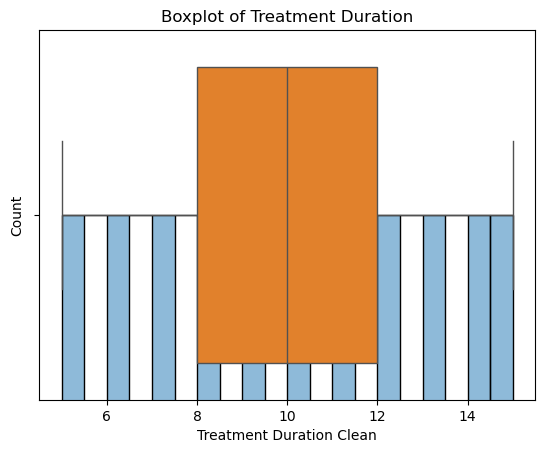


✅ All models trained on clean, deduplicated, engineered data.


In [13]:
# Typhoid Suspected
print("\n🔍 Training Suspected Typhoid Model (Augmented Data)...")

# Select only numeric or boolean features
X_aug = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()

# Columns to drop
drop_cols = MED_COLS + [
    'Salmonella_Presence', 'Suspected_Typhoid', 'Patient ID',
    'Treatment Duration', 'Intensity_Score',
    'Hemoglobin_Status', 'Potassium_Status',
    'PC1', 'PC2', 'Calcium_Status'
]

# Convert to numeric and coerce errors
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')

# Drop leakage columns
X_aug.drop(columns=[col for col in drop_cols if col in X_aug.columns], inplace=True)

# Target
yty_aug = augmented_train_df['Suspected_Typhoid'].astype(int)

# -----------------------------------------------
# 🤝 FIX LENGTH MISMATCH BEFORE ANY SMOTE/Pipeline
# -----------------------------------------------
if len(X_aug) != len(yty_aug):
    print(f"⚠️ Length mismatch detected: X={len(X_aug)}, y={len(yty_aug)}")
    min_len = min(len(X_aug), len(yty_aug))
    X_aug = X_aug.iloc[:min_len, :]
    yty_aug = yty_aug[:min_len]
    print(f"✔ Length corrected → {min_len} rows")

# -----------------------------------------------
# ✅ CORRECT SMOTE USAGE:
#    SMOTE must ONLY be inside CV pipeline
# -----------------------------------------------
print("\n🔧 Using SAFE PIPELINE: Imputer → SMOTE → XGB (inside CV only)")

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline_typh = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # fixes NaNs before SMOTE
    ("smote", SMOTE(random_state=SEED)),            # applied ONLY to training folds
    ("clf", XGBClassifier(eval_metric='logloss', random_state=SEED))
])

# -----------------------------------------------
# CORRELATION CHECK (unchanged)
# -----------------------------------------------
print("\n🔬 Checking highly correlated feature pairs (Typhoid Model)...")

corr_matrix_typh = X_aug.corr().abs()
upper_typh = corr_matrix_typh.where(np.triu(np.ones(corr_matrix_typh.shape), k=1).astype(bool))

high_corr_pairs_typh = (
    upper_typh.stack()
    .sort_values(ascending=False)
    .reset_index()
)
high_corr_pairs_typh.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs_typh = high_corr_pairs_typh[high_corr_pairs_typh['Correlation'] > 0.9]

print("\n🔍 Highly Correlated Feature Pairs in Typhoid Model:")
print(high_corr_pairs_typh)

# -----------------------------------------------
# CV + Hyperparameter grid (UNCHANGED)
# -----------------------------------------------
cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cls_param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.7, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.9, 1.0],
    'clf__gamma': [0, 1, 3],
    'clf__reg_lambda': [0.1, 1, 10]
}

# -----------------------------------------------
# SEARCH (uses pipeline_typh instead of raw XGB)
# -----------------------------------------------
search_typh = RandomizedSearchCV(
    estimator=pipeline_typh,
    param_distributions=cls_param_grid,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv_cls,
    verbose=1,
    random_state=SEED
)

print("🔍 Training Suspected Typhoid Model (Impute + SMOTE inside CV)...")
search_typh.fit(X_aug, yty_aug)

# -----------------------------------------------
# DIAGNOSTICS (UNCHANGED)
# -----------------------------------------------
print("\n📝 Features used in final model:")
print(list(X_aug.columns))

print("\n📊 Data types of features:")
print(X_aug.dtypes.value_counts())

print("\n🏁 Best CV ROC AUC score:")
print(search_typh.best_score_)

print("\n✅ Typhoid Classification Model (safe, no leakage):")
print(search_typh.best_params_)

# -----------------------------------------------
# Save model + feature list (UNCHANGED)
# -----------------------------------------------
joblib.dump(search_typh.best_estimator_, "xgb_model_typhoid.pkl")

feat_typhoid = list(X_aug.columns)
joblib.dump(feat_typhoid, "X_features_typhoid.joblib")

augmented_train_df[['Patient ID']].join(X_aug).to_csv("processed/X_train_typhoid_pipeline.csv", index=False)

sns.histplot(ydur_aug, kde=True)

sns.boxplot(x=ydur_aug)
plt.title("Boxplot of Treatment Duration")
plt.show()

print("\n✅ All models trained on clean, deduplicated, engineered data.")



🔍 Training Outcome Model (Original Data + Engineered, No Leakage)...
✅ No columns with all missing values.

🔎 Missing value breakdown in dropped rows:
Severity_Score    408
dtype: int64
📏 Rows before dropping NaNs: 3888
📉 Dropped rows with NaNs: 408
📏 Rows after dropping NaNs: 3480

🔬 Checking highly correlated feature pairs (Outcome Model)...

🔍 Highly Correlated Feature Pairs in Outcome Model:
                 Feature 1                     Feature 2  Correlation
0  SimMet_EnergyDisruption          SimMet_HypoxiaStress     1.000000
1       Potassium (mmol/L)  SimMet_ElectrolyteDisruption     0.906015
Original outcome class distribution: Counter({1.0: 1895, 0.0: 1585})
Balanced outcome class distribution: Counter({0.0: 1895, 1.0: 1895})
Fitting 5 folds for each of 30 candidates, totalling 150 fits

📝 Features used in final model:
['Age', 'Hemoglobin (g/dL)', 'Platelet Count', 'Calcium (mg/dL)', 'Potassium (mmol/L)', 'Severity_Score', 'Culture_Concordance', 'Salmonella_Presence', 'Cult

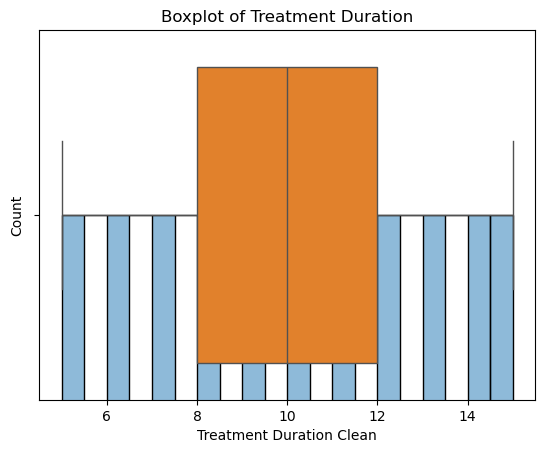


✅ All models trained on clean, deduplicated, engineered data.


In [14]:
# ----------------------------------------------------------------------
# 4b. SAFE OUTCOME MODEL TRAINING (Original + Engineered, No Leakage)
# ----------------------------------------------------------------------
print("\n🔍 Training Outcome Model (Original Data + Engineered, No Leakage)...")

# Filter to original data only
#original_only_df = augmented_train_df[augmented_train_df["Source"] == "Original"].copy()

# Define target
outcome_y = augmented_train_df['Treatment Outcome']

# Convert to numeric and coerce errors
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')

outcome_X = (
    augmented_train_df
    .drop(columns=[
        'Treatment Outcome', 'Treatment Duration', 'Patient ID',
        'Resistance_Proxy_Score', 'Normalized_Duration', 'Treatment Duration Clean',
        'Hemoglobin_Status', 'Potassium_Status', 'Intensity_Score',
        'PC1', 'PC2', 'Calcium_Status'
    ], errors='ignore')
    .select_dtypes(include=[np.number, 'bool'])
)

# Stratified cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Hyperparameter search grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 3, 5],
    'reg_lambda': [0.1, 1, 10]
}

xgb_clf = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)

# Check for fully missing columns
nan_columns = outcome_X.columns[outcome_X.isnull().all()]
if len(nan_columns) > 0:
    print("⚠️ Columns with all NaNs (dropping):", list(nan_columns))
    outcome_X.drop(columns=nan_columns, inplace=True)
else:
    print("✅ No columns with all missing values.")

# Define valid rows now (before using it)
valid_rows = outcome_X.notnull().all(axis=1) & outcome_y.notnull()

# Investigate what columns are missing in the dropped rows
nan_summary = outcome_X[~valid_rows].isnull().sum().sort_values(ascending=False)
print("\n🔎 Missing value breakdown in dropped rows:")
print(nan_summary[nan_summary > 0])

os.makedirs("diagnostics", exist_ok=True)

# Optional: Save dropped rows for manual inspection
outcome_X[~valid_rows].assign(Target=outcome_y[~valid_rows]).to_csv(
    "diagnostics/dropped_outcome_rows_with_nans.csv", index=False
)

# Drop rows with NaNs in X or y
print(f"📏 Rows before dropping NaNs: {outcome_X.shape[0]}")
dropped_count = (~valid_rows).sum()
outcome_X = outcome_X[valid_rows]
outcome_y = outcome_y[valid_rows]
print(f"📉 Dropped rows with NaNs: {dropped_count}")
print(f"📏 Rows after dropping NaNs: {outcome_X.shape[0]}")

print("\n🔬 Checking highly correlated feature pairs (Outcome Model)...")

# Compute correlation matrix
corr_matrix = outcome_X.corr().abs()

# Take upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Extract feature pairs with high correlation > 0.9
high_corr_pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .reset_index()
)
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.9]

# Show results
print("\n🔍 Highly Correlated Feature Pairs in Outcome Model:")
print(high_corr_pairs)

print(f"Original outcome class distribution: {Counter(outcome_y)}")
sm = SMOTE(random_state=SEED)
outcome_X, outcome_y = sm.fit_resample(outcome_X, outcome_y)
print(f"Balanced outcome class distribution: {Counter(outcome_y)}")
# Train logistic regression on same SMOTE-balanced data
#lr_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
#lr_auc_scores = cross_val_score(lr_clf, outcome_X, outcome_y, scoring='roc_auc', cv=cv_strategy)

#print(f"\n📊 Logistic Regression CV ROC AUC scores: {lr_auc_scores}")
#print(f"✅ Logistic Regression Mean ROC AUC: {lr_auc_scores.mean():.4f}")
# Fit logistic regression on full SMOTE-balanced data
#lr_clf.fit(outcome_X, outcome_y)
# Save logistic regression model
#joblib.dump(lr_clf, "logistic_model_outcome.pkl")

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv_strategy,
    verbose=1,
    random_state=SEED
)

search.fit(outcome_X, outcome_y)
print("\n📝 Features used in final model:")
print(list(outcome_X.columns))

print("\n📊 Data types of features:")
print(outcome_X.dtypes.value_counts())
print("\n🏁 Best CV ROC AUC score:")
print(search.best_score_)

print("\n✅ Outcome Model (Re-trained safely with engineered features):")
print(search.best_params_)

# Save model and encoder
joblib.dump(search.best_estimator_, "xgb_model_outcome.pkl")
joblib.dump(bact_enc, "label_encoder_bacteria.pkl")
# Save outcome feature names
feat_outcome = list(outcome_X.columns)  # outcome_X is your training features for outcome
joblib.dump(feat_outcome, "X_features_outcome.joblib")

# Save X with ID for future use
augmented_train_df[['Patient ID']].join(outcome_X).to_csv("processed/X_train_outcome_pipeline.csv", index=False)

#Typhoid Suspected
print("\n🔍 Training Suspected Typhoid Model (Augmented Data)...")

# Select only numeric or boolean features
X_aug = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()

# Drop medication columns, duration/resistance leaks, and ID
drop_cols = MED_COLS + [
    'Salmonella_Presence', 'Suspected_Typhoid', 'Patient ID',
    'Treatment Duration', 'Intensity_Score',
    'Hemoglobin_Status', 'Potassium_Status',
    'PC1', 'PC2', 'Calcium_Status'
]

# Convert to numeric and coerce errors
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')

X_aug.drop(columns=[col for col in drop_cols if col in X_aug.columns], inplace=True)

# Target
yty_aug = augmented_train_df['Suspected_Typhoid'].astype(int)

# SMOTE for class imbalance
cnt = Counter(yty_aug)
if max(cnt.values()) / min(cnt.values()) > 1.5:
    sm = SMOTE(random_state=SEED)
    X_typh, y_typh = sm.fit_resample(X_aug, yty_aug)
    print(f"✅ SMOTE applied. Class distribution: {Counter(y_typh)}")
else:
    X_typh, y_typh = X_aug.copy(), yty_aug.copy()
    print(f"✅ SMOTE not needed. Class distribution: {cnt}")

# === CHECK HIGHLY CORRELATED FEATURE PAIRS ===
print("\n🔬 Checking highly correlated feature pairs (Typhoid Model)...")

# Compute correlation matrix
corr_matrix_typh = X_typh.corr().abs()

# Take upper triangle of correlation matrix
upper_typh = corr_matrix_typh.where(np.triu(np.ones(corr_matrix_typh.shape), k=1).astype(bool))

# Extract feature pairs with high correlation > 0.9
high_corr_pairs_typh = (
    upper_typh.stack()
    .sort_values(ascending=False)
    .reset_index()
)
high_corr_pairs_typh.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs_typh = high_corr_pairs_typh[high_corr_pairs_typh['Correlation'] > 0.9]

# Show results
print("\n🔍 Highly Correlated Feature Pairs in Typhoid Model:")
print(high_corr_pairs_typh)

# CV & hyperparam grid
cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cls_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 3],
    'reg_lambda': [0.1, 1, 10]
}

# Search
search_typh = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=SEED),
    param_distributions=cls_param_grid,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv_cls,
    verbose=1,
    random_state=SEED
)
search_typh.fit(X_typh, y_typh)

# Diagnostics
print("\n📝 Features used in final model:")
print(list(X_typh.columns))

print("\n📊 Data types of features:")
print(X_typh.dtypes.value_counts())

print("\n🏁 Best CV ROC AUC score:")
print(search_typh.best_score_)

print("\n✅ Typhoid Classification Model (Re-trained safely with engineered features):")
print(search_typh.best_params_)

# Save model
joblib.dump(search_typh.best_estimator_, "xgb_model_typhoid.pkl")
# Save the actual features used (after dropping leaks)
feat_typhoid = list(X_typh.columns)  # X_typh after SMOTE (or X_aug if no SMOTE)
joblib.dump(feat_typhoid, "X_features_typhoid.joblib")

# Save X with ID for future use
augmented_train_df[['Patient ID']].join(X_typh).to_csv("processed/X_train_typhoid_pipeline.csv", index=False)

sns.histplot(ydur_aug, kde=True)

sns.boxplot(x=ydur_aug)
plt.title("Boxplot of Treatment Duration")
plt.show()

print("\n✅ All models trained on clean, deduplicated, engineered data.")

### Evaluation for all models on test set

In [15]:
#EVALUATION AND REFITING

# === Directories ===
os.makedirs("evaluation_outputs/plots", exist_ok=True)
os.makedirs("evaluation_outputs/text", exist_ok=True)

# === Constants ===
MED_COLS = ["Medication_Amoxicillin", "Medication_Azithromycin", "Medication_Ceftriaxone"]

# === Helper Functions ===
def plot_cm(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.savefig(filename, dpi=600)
    plt.close()

def plot_roc(y_true, y_prob, title, filename):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, dpi=600)
    plt.close()

def plot_regression(y_true, y_pred, title, filename):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.close()

def plot_residuals(y_true, y_pred, title, filename):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolors='k')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.close()

def plot_qq(y_true, y_pred, title, filename):
    residuals = y_true - y_pred
    plt.figure()
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.close()

# === Evaluation Loop ===
duration_preds = []
resistance_preds = []
outcome_probs = []
typhoid_probs = []
metrics = []

for i in range(10):
    seed = 100 + i
    np.random.seed(seed)
    random.seed(seed)

    # Load data
    X_te_duration_df = joblib.load("intermediate_data/X_te_duration.joblib")
    feat_duration = joblib.load("X_features_duration.joblib")
    X_te_duration = X_te_duration_df[feat_duration]

    X_te_resistance = joblib.load("intermediate_data/X_te_resistance.joblib")
    feat_resistance = joblib.load("X_features_resistance.joblib")
    X_te_resistance = X_te_resistance[feat_resistance]

    X_te_typhoid = joblib.load("intermediate_data/X_te_typhoid.joblib")
    feat_typhoid = joblib.load("X_features_typhoid.joblib")
    X_te_typhoid = X_te_typhoid[feat_typhoid]

    X_te_outcome_df = pd.read_csv("intermediate_data/test_data.csv")
    feat_outcome = joblib.load("X_features_outcome.joblib")
    X_te_outcome = X_te_outcome_df[feat_outcome]

    ydur_te = joblib.load("intermediate_data/ydur_te.joblib")
    yres_te = joblib.load("intermediate_data/yres_te.joblib")
    yty_te = joblib.load("intermediate_data/yty_te.joblib")
    y_outcome_te = joblib.load("intermediate_data/y_outcome_te.joblib")

    mdl_duration = joblib.load("xgb_model_duration.pkl")
    mdl_resistance = joblib.load("xgb_model_resistance.pkl")
    mdl_typhoid = joblib.load("xgb_model_typhoid.pkl")
    mdl_outcome = joblib.load("xgb_model_outcome.pkl")

    pred_duration = mdl_duration.predict(X_te_duration)
    pred_resistance = mdl_resistance.predict(X_te_resistance)
    pred_typhoid_prob = mdl_typhoid.predict_proba(X_te_typhoid)[:, 1]
    pred_outcome_prob = mdl_outcome.predict_proba(X_te_outcome)[:, 1]

    # Apply NaN masking per run for metrics
    mask_dur = ~np.isnan(ydur_te) & ~np.isnan(pred_duration)
    mask_res = ~np.isnan(yres_te) & ~np.isnan(pred_resistance)

    metrics.append({
        "duration_r2": r2_score(ydur_te[mask_dur], pred_duration[mask_dur]),
        "duration_mae": mean_absolute_error(ydur_te[mask_dur], pred_duration[mask_dur]),
        "resistance_r2": r2_score(yres_te[mask_res], pred_resistance[mask_res]),
        "resistance_mae": mean_absolute_error(yres_te[mask_res], pred_resistance[mask_res]),
        "outcome_roc_auc": roc_auc_score(y_outcome_te, pred_outcome_prob),
        "typhoid_roc_auc": roc_auc_score(yty_te, pred_typhoid_prob)
    })

    duration_preds.append(pred_duration)
    resistance_preds.append(pred_resistance)
    outcome_probs.append(pred_outcome_prob)
    typhoid_probs.append(pred_typhoid_prob)

# === Average Predictions ===
pred_duration_avg = np.mean(duration_preds, axis=0)
pred_resistance_avg = np.mean(resistance_preds, axis=0)
pred_outcome_prob_avg = np.mean(outcome_probs, axis=0)
pred_typhoid_prob_avg = np.mean(typhoid_probs, axis=0)

pred_outcome_lbl_avg = (pred_outcome_prob_avg >= 0.5).astype(int)
pred_typhoid_lbl_avg = (pred_typhoid_prob_avg >= 0.5).astype(int)

# === Save Reports ===
# === Save Reports with NaN Masking ===

# Duration
mask_dur = ~np.isnan(ydur_te) & ~np.isnan(pred_duration_avg)
y_true_dur = ydur_te[mask_dur]
y_pred_dur = pred_duration_avg[mask_dur]
mse_dur = mean_squared_error(y_true_dur, y_pred_dur)

with open(f"evaluation_outputs/text/duration_report.txt", "w") as f:
    f.write("=== Treatment Duration Regression ===\n")
    f.write(f"R2:   {r2_score(y_true_dur, y_pred_dur):.4f}\n")
    f.write(f"MAE:  {mean_absolute_error(y_true_dur, y_pred_dur):.4f}\n")
    f.write(f"MSE:  {mse_dur:.4f}\n")
    f.write(f"RMSE: {np.sqrt(mse_dur):.4f}\n")

# Resistance
mask_res = ~np.isnan(yres_te) & ~np.isnan(pred_resistance_avg)
y_true_res = yres_te[mask_res]
y_pred_res = pred_resistance_avg[mask_res]
mse_res = mean_squared_error(y_true_res, y_pred_res)

with open(f"evaluation_outputs/text/resistance_report.txt", "w") as f:
    f.write("=== Resistance Proxy Regression ===\n")
    f.write(f"R2:   {r2_score(y_true_res, y_pred_res):.4f}\n")
    f.write(f"MAE:  {mean_absolute_error(y_true_res, y_pred_res):.4f}\n")
    f.write(f"MSE:  {mse_res:.4f}\n")
    f.write(f"RMSE: {np.sqrt(mse_res):.4f}\n")

with open("evaluation_outputs/text/outcome_report.txt", "w") as f:
    f.write("=== Outcome Model ===\n")
    f.write(classification_report(y_outcome_te, pred_outcome_lbl_avg))
    f.write(f"\nROC AUC: {roc_auc_score(y_outcome_te, pred_outcome_prob_avg):.4f}\n")

with open("evaluation_outputs/text/typhoid_report.txt", "w") as f:
    f.write("=== Typhoid Model ===\n")
    f.write(classification_report(yty_te, pred_typhoid_lbl_avg))
    f.write(f"\nROC AUC: {roc_auc_score(yty_te, pred_typhoid_prob_avg):.4f}\n")

# === Individual Plots ===
plot_cm(y_outcome_te, pred_outcome_lbl_avg, "Outcome - Confusion Matrix", "evaluation_outputs/plots/cm_outcome.png")
plot_roc(y_outcome_te, pred_outcome_prob_avg, "Outcome - ROC Curve", "evaluation_outputs/plots/roc_outcome.png")

plot_cm(yty_te, pred_typhoid_lbl_avg, "Typhoid - Confusion Matrix", "evaluation_outputs/plots/cm_typhoid.png")
plot_roc(yty_te, pred_typhoid_prob_avg, "Typhoid - ROC Curve", "evaluation_outputs/plots/roc_typhoid.png")

plot_regression(ydur_te, pred_duration_avg, "Treatment Duration - Regression", "evaluation_outputs/plots/reg_duration.png")
plot_residuals(ydur_te, pred_duration_avg, "Treatment Duration - Residuals", "evaluation_outputs/plots/resid_duration.png")
plot_qq(ydur_te, pred_duration_avg, "Treatment Duration - QQ Plot", "evaluation_outputs/plots/qq_duration.png")

plot_regression(yres_te, pred_resistance_avg, "Resistance Score - Regression", "evaluation_outputs/plots/reg_resistance.png")
plot_residuals(yres_te, pred_resistance_avg, "Resistance Score - Residuals", "evaluation_outputs/plots/resid_resistance.png")
plot_qq(yres_te, pred_resistance_avg, "Resistance Score - QQ Plot", "evaluation_outputs/plots/qq_resistance.png")

# === Combined Grid: ROC + Residuals ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC Curve - Outcome
fpr, tpr, _ = roc_curve(y_outcome_te, pred_outcome_prob_avg)
auc = roc_auc_score(y_outcome_te, pred_outcome_prob_avg)
axes[0, 0].plot(fpr, tpr, label=f"AUC = {auc:.4f}")
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_title("A. Outcome ROC Curve")
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate")
axes[0, 0].legend()
axes[0, 0].grid(True)

# ROC Curve - Typhoid
fpr, tpr, _ = roc_curve(yty_te, pred_typhoid_prob_avg)
auc = roc_auc_score(yty_te, pred_typhoid_prob_avg)
axes[0, 1].plot(fpr, tpr, label=f"AUC = {auc:.4f}")
axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_title("B. Typhoid ROC Curve")
axes[0, 1].set_xlabel("False Positive Rate")
axes[0, 1].set_ylabel("True Positive Rate")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Residual Plot - Duration
resid = ydur_te - pred_duration_avg
axes[1, 0].scatter(pred_duration_avg, resid, alpha=0.5, edgecolors='k')
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title("C. Duration Residuals")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Residuals")
axes[1, 0].grid(True)

# Residual Plot - Resistance
resid = yres_te - pred_resistance_avg
axes[1, 1].scatter(pred_resistance_avg, resid, alpha=0.5, edgecolors='k')
axes[1, 1].axhline(0, color='r', linestyle='--')
axes[1, 1].set_title("D. Resistance Residuals")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig("evaluation_outputs/plots/grid_main_roc_residuals.png", dpi=600)
plt.close()

# === Combined Grid: Confusion Matrix + QQ Plots ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Confusion Matrix - Outcome
cm_out = confusion_matrix(y_outcome_te, pred_outcome_lbl_avg)
disp = ConfusionMatrixDisplay(cm_out)
disp.plot(ax=axes[0, 0], cmap='Blues', colorbar=False)
axes[0, 0].set_title("A. Outcome Confusion Matrix")

# Confusion Matrix - Typhoid
cm_typ = confusion_matrix(yty_te, pred_typhoid_lbl_avg)
disp = ConfusionMatrixDisplay(cm_typ)
disp.plot(ax=axes[0, 1], cmap='Blues', colorbar=False)
axes[0, 1].set_title("B. Typhoid Confusion Matrix")

# QQ Plot - Duration
stats.probplot(ydur_te - pred_duration_avg, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("C. Duration QQ Plot")
axes[1, 0].grid(True)

# QQ Plot - Resistance
stats.probplot(yres_te - pred_resistance_avg, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("D. Resistance QQ Plot")
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig("evaluation_outputs/plots/grid_supplementary_cm_qq.png", dpi=600)
plt.close()


# === Print Mean ± SD of Metrics ===
print("\n📊 Averaged Evaluation Metrics over 10 runs:\n")
metrics_df = pd.DataFrame(metrics)
summary = metrics_df.agg(['mean', 'std'])
for metric in metrics_df.columns:
    mean = summary.loc['mean', metric]
    std = summary.loc['std', metric]
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

print("\n✅ Evaluation complete. Averaged plots and reports saved in 'evaluation_outputs/'")


📊 Averaged Evaluation Metrics over 10 runs:

duration_r2: 0.8092 ± 0.0000
duration_mae: 0.7776 ± 0.0000
resistance_r2: 0.9051 ± 0.0000
resistance_mae: 0.7403 ± 0.0000
outcome_roc_auc: 0.9996 ± 0.0000
typhoid_roc_auc: 0.9870 ± 0.0000

✅ Evaluation complete. Averaged plots and reports saved in 'evaluation_outputs/'


In [16]:
#XGBoost CROSS-VALIDATED 10 TIMES WITH DIFFERENT SEEDS

# ===================================================================================
# 1. EXTRACT X AND y FROM YOUR EXISTING TRAINING CODE BLOCKS
# ===================================================================================

# --- Duration Model X and y ---
X_duration = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()
drop_cols_dur = [
    'Normalized_Duration', 'Resistance_Proxy_Score', 'Treatment Duration',
    'Treatment Duration Clean', 'Patient ID',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status',
    'PC1', 'PC2'
]
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')
X_duration.drop(columns=[c for c in drop_cols_dur if c in X_duration.columns], inplace=True)
X_duration = X_duration.replace([np.inf, -np.inf], np.nan).dropna()
y_duration = augmented_train_df.loc[X_duration.index, 'Treatment Duration Clean']

# --- Resistance Model X and y ---
X_res = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()
drop_cols_res = [
    'Normalized_Duration', 'Resistance_Proxy_Score', 'Treatment Duration',
    'Treatment Duration Clean', 'Patient ID', 'Culture_Concordance', 'Severity_Score',
    'Hemoglobin_Status', 'Platelet_Status', 'Calcium_Status', 'Potassium_Status',
    'PC1', 'PC2'
]
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')
X_res.drop(columns=[c for c in drop_cols_res if c in X_res.columns], inplace=True)
nan_mask = augmented_train_df['Resistance_Proxy_Score'].replace([np.inf, -np.inf], np.nan).isna()
X_res = X_res[~nan_mask]
y_res = augmented_train_df.loc[X_res.index, 'Resistance_Proxy_Score']

# --- Typhoid Model X and y ---
X_ty = augmented_train_df.select_dtypes(include=[np.number, 'bool']).copy()
drop_cols_ty = MED_COLS + [
    'Salmonella_Presence', 'Suspected_Typhoid', 'Patient ID',
    'Treatment Duration', 'Intensity_Score',
    'Hemoglobin_Status', 'Potassium_Status',
    'PC1', 'PC2', 'Calcium_Status'
]
for col in ['Age', 'Platelet Count']:
    augmented_train_df[col] = pd.to_numeric(augmented_train_df[col], errors='coerce')
X_ty.drop(columns=[c for c in drop_cols_ty if c in X_ty.columns], inplace=True)
y_ty = augmented_train_df['Suspected_Typhoid'].astype(int)

# --- Outcome Model X and y (same structure as your main outcome pipeline) ---
outcome_feature_cols = joblib.load("X_features_outcome.joblib")
X_outcome = augmented_train_df[outcome_feature_cols].copy()
y_outcome = augmented_train_df['Treatment Outcome']  # Change if your column name differs


# ===================================================================================
# 2. UNIVERSAL NESTED CV FUNCTION (classifier or regressor)
# ===================================================================================

def run_repeated_cv(model_type, X, y, metric_name, scoring):
    seeds = range(100, 110)
    means = []

    for seed in seeds:
        if model_type == "clf":
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
            model = XGBClassifier(
                eval_metric='logloss',
                random_state=seed
            )
        else:
            cv = KFold(n_splits=5, shuffle=True, random_state=seed)
            model = XGBRegressor(
                objective="reg:squarederror",
                random_state=seed
            )

        scores = cross_val_score(
            model,
            X, y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        means.append(scores.mean())

    return f"{metric_name}: {np.mean(means):.4f} ± {np.std(means):.4f}"


# ===================================================================================
# 3. RUN ALL MODELS → STORE TEXT OUTPUT
# ===================================================================================

summary = []

# Duration Model: R2 and MAE
summary.append(run_repeated_cv("reg", X_duration, y_duration, "duration_r2", "r2"))
summary.append(run_repeated_cv("reg", X_duration, y_duration, "duration_mae", "neg_mean_absolute_error"))

# Resistance Model: R2 and MAE
summary.append(run_repeated_cv("reg", X_res, y_res, "resistance_r2", "r2"))
summary.append(run_repeated_cv("reg", X_res, y_res, "resistance_mae", "neg_mean_absolute_error"))

# Outcome Model: ROC AUC
summary.append(run_repeated_cv("clf", X_outcome, y_outcome, "outcome_roc_auc", "roc_auc"))

# Typhoid Model: ROC AUC
summary.append(run_repeated_cv("clf", X_ty, y_ty, "typhoid_roc_auc", "roc_auc"))

# ===================================================================================
# 4. PRINT FINAL SUMMARY
# ===================================================================================

print("\n📊 Averaged Evaluation Metrics over 10 runs:\n")
for line in summary:
    print(line)



📊 Averaged Evaluation Metrics over 10 runs:

duration_r2: 0.7937 ± 0.0045
duration_mae: -0.8012 ± 0.0097
resistance_r2: 0.8992 ± 0.0012
resistance_mae: -0.7671 ± 0.0062
outcome_roc_auc: 0.9997 ± 0.0002
typhoid_roc_auc: 0.9829 ± 0.0009


In [17]:
#REAL FULL NESTED HYPERPARAMETER TUNING (OUTER CV + INNER RANDOMIZEDSEARCHCV).

# ==========================================================
# 1. PARAM GRID USED BY ALL MODELS
# ==========================================================
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 3, 5],
    "reg_lambda": [0.1, 1, 10],
}

# ==========================================================
# 2. UNIVERSAL NESTED CV FUNCTION
# ==========================================================
def run_nested_cv(model_type, X, y, metric_name, scoring):
    print(f"\n\n🔁 Running FULL repeated nested CV for: {metric_name}")

    seeds = range(100, 110)
    all_seeds_means = []

    for seed in seeds:
        print(f"\n➡ Seed {seed}")
        outer_scores = []

        # Choose CV strategy
        if model_type == "clf":
            outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        else:
            outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

        # Choose model
        if model_type == "clf":
            base_model = XGBClassifier(eval_metric="logloss", random_state=seed)
        else:
            base_model = XGBRegressor(
                objective="reg:squarederror", random_state=seed
            )

        # Inner CV
        if model_type == "clf":
            inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        else:
            inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

        # Randomized hyperparameter search
        rsearch = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grid,
            n_iter=30,
            scoring=scoring,
            cv=inner_cv,
            n_jobs=-1,
            random_state=seed
        )

        # Outer CV → final unbiased evaluation
        scores = cross_val_score(
            rsearch,
            X,
            y,
            cv=outer_cv,
            scoring=scoring,
            n_jobs=-1
        )

        print(f"   Outer scores: {scores} → Mean: {scores.mean():.4f}")

        outer_scores.append(scores.mean())
        all_seeds_means.append(scores.mean())

    # Final aggregated results over 10 seeds
    final_mean = np.mean(all_seeds_means)
    final_std = np.std(all_seeds_means)

    return f"{metric_name}: {final_mean:.4f} ± {final_std:.4f}"


# ==========================================================
# 3. RUN ALL MODELS
#    (Replace X_*, y_* with your prepared matrices)
# ==========================================================
summary = []

summary.append(run_nested_cv("reg", X_duration, y_duration,
                             "duration_r2", "r2"))
summary.append(run_nested_cv("reg", X_duration, y_duration,
                             "duration_mae", "neg_mean_absolute_error"))

summary.append(run_nested_cv("reg", X_res, y_res,
                             "resistance_r2", "r2"))
summary.append(run_nested_cv("reg", X_res, y_res,
                             "resistance_mae", "neg_mean_absolute_error"))

summary.append(run_nested_cv("clf", X_outcome, y_outcome,
                             "outcome_roc_auc", "roc_auc"))

summary.append(run_nested_cv("clf", X_ty, y_ty,
                             "typhoid_roc_auc", "roc_auc"))

# ==========================================================
# 4. PRINT FINAL SUMMARY
# ==========================================================
print("\n\n📊 FINAL RESULTS (Repeated Nested CV):\n")
for line in summary:
    print(line)





🔁 Running FULL repeated nested CV for: duration_r2

➡ Seed 100
   Outer scores: [0.79753236 0.81479654 0.79132698 0.79090946 0.78364781] → Mean: 0.7956

➡ Seed 101
   Outer scores: [0.80900495 0.7966239  0.83229277 0.80725823 0.79504995] → Mean: 0.8080

➡ Seed 102
   Outer scores: [0.78699227 0.82889222 0.83171472 0.81476341 0.79984339] → Mean: 0.8124

➡ Seed 103
   Outer scores: [0.79169646 0.81142239 0.78228167 0.81275889 0.82283624] → Mean: 0.8042

➡ Seed 104
   Outer scores: [0.81520306 0.75783252 0.78857426 0.82956835 0.81094546] → Mean: 0.8004

➡ Seed 105
   Outer scores: [0.79557462 0.79320968 0.81892869 0.78157078 0.81339489] → Mean: 0.8005

➡ Seed 106
   Outer scores: [0.78055617 0.82153444 0.82225502 0.81071492 0.78544938] → Mean: 0.8041

➡ Seed 107
   Outer scores: [0.79557738 0.81700656 0.80196374 0.76153063 0.81881931] → Mean: 0.7990

➡ Seed 108
   Outer scores: [0.76228165 0.8146445  0.82909928 0.82488583 0.80959647] → Mean: 0.8081

➡ Seed 109
   Outer scores: [0.792645

### Explainability summary per model per model

In [18]:
# ----------------------------
# SETUP
# ----------------------------
output_dir = "explainability"
os.makedirs(output_dir, exist_ok=True)

model_paths = {
    "Outcome": "xgb_model_outcome.pkl",
    "Duration": "xgb_model_duration.pkl",
    "Resistance": "xgb_model_resistance.pkl",
    "Typhoid": "xgb_model_typhoid.pkl"
}

# Load your full test dataset
X_full = pd.read_csv("intermediate_data/test_data.csv")
X_full = X_full.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

# ============================================================
# MAIN LOOP — SHAP FOR EACH MODEL
# ============================================================
for model_name, model_path in model_paths.items():
    print(f"[INFO] Generating explainability for: {model_name}")

    # ----------------------------
    # Load model
    # ----------------------------
    model_loaded = joblib.load(model_path)

    # If pipeline, extract final estimator (commonly named 'clf')
    if hasattr(model_loaded, "named_steps"):
        final_model = model_loaded.named_steps.get("clf", list(model_loaded.named_steps.values())[-1])
    else:
        final_model = model_loaded

    # ----------------------------
    # Get model feature names
    # ----------------------------
    model_features = None

    # 1️⃣ Special case for Typhoid: load saved feature list
    if model_name == "Typhoid":
        feat_file = "X_features_typhoid.joblib"
        if os.path.exists(feat_file):
            model_features = joblib.load(feat_file)
        else:
            print(f"[WARN] {model_name}: feature list file not found, using fallback test columns.")

    # 2️⃣ Preferred: scikit-learn wrapper
    if model_features is None:
        try:
            model_features = list(final_model.feature_names_in_)
        except Exception:
            pass

    # 3️⃣ Fallback: XGBoost booster
    if model_features is None:
        try:
            model_features = list(final_model.get_booster().feature_names)
        except Exception:
            model_features = None

    # 4️⃣ Final fallback: use test columns
    if model_features is None:
        print(f"[WARN] {model_name}: no feature names found on model — falling back to test set columns.")
        model_features = list(X_full.columns)

    # Clean feature names
    model_features = [f for f in model_features if f is not None and str(f).strip() != ""]

    # Build X_input with exact features expected by model
    missing = [f for f in model_features if f not in X_full.columns]
    if missing:
        print(f"[WARN] {model_name}: {len(missing)} expected features missing in test set. Filling with zeros: {missing[:5]}{'...' if len(missing)>5 else ''}")

    data_dict = {f: X_full[f].values if f in X_full.columns else np.zeros(len(X_full), dtype=np.float32)
                 for f in model_features}
    X_input = pd.DataFrame(data_dict, index=X_full.index)

    # Ensure numeric dtype
    X_input = X_input.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

    # ----------------------------
    # SHAP explainer
    # ----------------------------
    try:
        explainer = shap.TreeExplainer(final_model)
        shap_vals = explainer(X_input)
    except Exception as e_tree:
        try:
            explainer = shap.Explainer(final_model, X_input)
            shap_vals = explainer(X_input)
        except Exception as e_generic:
            print(f"[ERROR] {model_name}: SHAP explainer failed ({e_tree} / {e_generic}). Skipping.")
            continue

    # ----------------------------
    # Create waterfall image
    # ----------------------------
    buf = BytesIO()
    plt.figure(figsize=(7, 5))
    try:
        shap.plots.waterfall(shap_vals[0], max_display=7, show=False)
    except Exception as e_w:
        print(f"[WARN] {model_name}: waterfall failed ({e_w}), falling back to bar plot.")
        plt.clf()
        shap.plots.bar(shap_vals, max_display=7, show=False)
    plt.tight_layout()
    plt.savefig(buf, format='png', dpi=300)
    plt.close()
    buf.seek(0)
    waterfall_img = Image.open(buf)

    # ----------------------------
    # Multi-panel report
    # ----------------------------
    fig = plt.figure(figsize=(18, 10))

    # Top-left: Text block
    ax0 = fig.add_axes([0.05, 0.58, 0.4, 0.35])
    ax0.axis("off")
    inputs_preview = "\n".join([f"- {col}" for col in X_input.columns[:5]]) + "\n- ..."
    text = f"""
Model: {model_name}
Inputs:
{inputs_preview}
Output:
- Predicted value (probability or score)

n_features = {X_input.shape[1]}
"""
    ax0.text(0.0, 1.0, text.strip(), va='top', fontsize=11)

    # Top-right: SHAP bar
    ax1 = fig.add_axes([0.52, 0.58, 0.43, 0.35])
    try:
        shap.plots.bar(shap_vals, max_display=7, show=False, ax=ax1)
    except Exception:
        plt.sca(ax1)
        shap.summary_plot(shap_vals.values if hasattr(shap_vals, "values") else shap_vals,
                          X_input, plot_type="bar", max_display=7, show=False)
    ax1.set_title("Top 7 SHAP Features", fontsize=11)

    # Bottom-left: Waterfall image
    ax2 = fig.add_axes([0.05, 0.08, 0.6, 0.4])
    ax2.imshow(waterfall_img)
    ax2.axis("off")
    ax2.set_title("Patient 0 - SHAP Waterfall", fontsize=11)

    # Bottom-right: Prediction value
    ax3 = fig.add_axes([0.7, 0.08, 0.25, 0.2])
    ax3.axis("off")
    try:
        pred_val = final_model.predict_proba(X_input.iloc[[0]])[0][1]
    except Exception:
        pred_val = final_model.predict(X_input.iloc[[0]])[0]

    ax3.text(0.1, 0.6, f"Example Patient ID: 0", fontsize=12)
    ax3.text(0.1, 0.4, f"Predicted Value: {pred_val:.3f}", fontsize=12)

    # Save
    out_path = os.path.join(output_dir, f"{model_name.lower()}_1pager.png")
    fig.savefig(out_path, dpi=600)
    plt.close(fig)

    print(f"[OK] Saved: {out_path}")

print("✅ All SHAP 1-pagers completed successfully.")


[INFO] Generating explainability for: Outcome
[OK] Saved: explainability\outcome_1pager.png
[INFO] Generating explainability for: Duration
[OK] Saved: explainability\duration_1pager.png
[INFO] Generating explainability for: Resistance
[OK] Saved: explainability\resistance_1pager.png
[INFO] Generating explainability for: Typhoid
[OK] Saved: explainability\typhoid_1pager.png
✅ All SHAP 1-pagers completed successfully.


### Cariberation

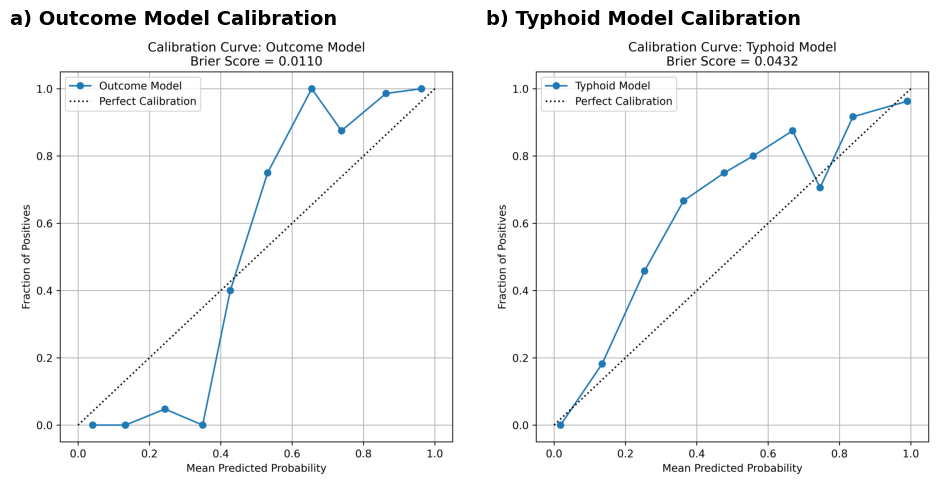

✅ Calibration plots saved in folder 'calibration/'


In [19]:
# === Setup ===
SEED = 42
np.random.seed(SEED)
output_dir = "calibration"
os.makedirs(output_dir, exist_ok=True)

# === Load Engineered Test Sets and Targets ===
Xo_test = joblib.load("intermediate_data/X_te_outcome.joblib")
yo_test = joblib.load("intermediate_data/y_outcome_te.joblib")

Xt_test = joblib.load("intermediate_data/X_te_typhoid.joblib")
yt_test = joblib.load("intermediate_data/yty_te.joblib")

# === Load Models ===
model_outcome = joblib.load("xgb_model_outcome.pkl")
model_typhoid = joblib.load("xgb_model_typhoid.pkl")

# === Ensure Feature Alignment for Outcome Model ===
expected_outcome_feats = joblib.load("X_features_outcome.joblib")
for col in expected_outcome_feats:
    if col not in Xo_test.columns:
        print(f"[INFO] Padding missing feature in Xo_test: {col}")
        Xo_test[col] = 0.0
Xo_test = Xo_test[expected_outcome_feats]

# === Calibration: Outcome Model ===
probs_out = model_outcome.predict_proba(Xo_test)[:, 1]
frac_pos_out, mean_pred_out = calibration_curve(yo_test, probs_out, n_bins=10)
brier_out = brier_score_loss(yo_test, probs_out)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_out, frac_pos_out, "o-", label='Outcome Model')
plt.plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title(f"Calibration Curve: Outcome Model\nBrier Score = {brier_out:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "calibration_outcome.png"), dpi=600)
plt.close()

# === Ensure Feature Alignment for Typhoid Model ===
typhoid_feats = model_typhoid.get_booster().feature_names
for col in typhoid_feats:
    if col not in Xt_test.columns:
        print(f"[INFO] Padding missing feature in Xt_test: {col}")
        Xt_test[col] = 0.0
Xt_test_filtered = Xt_test[typhoid_feats]

# === Calibration: Typhoid Model ===
probs_typ = model_typhoid.predict_proba(Xt_test_filtered)[:, 1]
frac_pos_typ, mean_pred_typ = calibration_curve(yt_test, probs_typ, n_bins=10)
brier_typ = brier_score_loss(yt_test, probs_typ)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_typ, frac_pos_typ, "o-", label='Typhoid Model')
plt.plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title(f"Calibration Curve: Typhoid Model\nBrier Score = {brier_typ:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "calibration_typhoid.png"), dpi=600)
plt.close()

# === Combine Both into Grid ===
import matplotlib.image as mpimg

outcome_path = os.path.join(output_dir, "calibration_outcome.png")
typhoid_path = os.path.join(output_dir, "calibration_typhoid.png")

out_img = mpimg.imread(outcome_path)
typ_img = mpimg.imread(typhoid_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(out_img)
axes[0].axis('off')
axes[0].set_title("a) Outcome Model Calibration", loc='left', fontsize=14, fontweight='bold')  # <-- Insert here

axes[1].imshow(typ_img)
axes[1].axis('off')
axes[1].set_title("b) Typhoid Model Calibration", loc='left', fontsize=14, fontweight='bold')  # <-- Insert here

plt.subplots_adjust(top=0.88, wspace=0.05)  # Add top margin and horizontal spacing
plt.savefig(os.path.join(output_dir, "calibration_grid.png"), dpi=600, bbox_inches='tight')
plt.show()

print("✅ Calibration plots saved in folder 'calibration/'")


### Drug Simulation and Reccommendations.

In [20]:
# Load models
mdl_duration   = joblib.load("xgb_model_duration.pkl")
mdl_resistance = joblib.load("xgb_model_resistance.pkl")
mdl_typhoid    = joblib.load("xgb_model_typhoid.pkl")
mdl_outcome    = joblib.load("xgb_model_outcome.pkl")

# Load features
feat_duration   = joblib.load("X_features_duration.joblib")
feat_resistance = joblib.load("X_features_resistance.joblib")
feat_typhoid    = joblib.load("X_features_typhoid.joblib")
feat_outcome    = joblib.load("X_features_outcome.joblib")

# Load processed test sets
X_te_duration   = joblib.load("intermediate_data/X_te_duration.joblib")
X_te_resistance = joblib.load("intermediate_data/X_te_resistance.joblib")
X_te_typhoid    = joblib.load("intermediate_data/X_te_typhoid.joblib")
X_te_outcome    = joblib.load("intermediate_data/X_te_outcome.joblib")
raw_test_df     = joblib.load("intermediate_data/raw_test_df.joblib")

# Drop Gender if present in test sets (it was not in training features)
for df in [X_te_duration, X_te_resistance, X_te_typhoid, X_te_outcome]:
    if 'Gender' in df.columns:
        df.drop(columns='Gender', inplace=True)

# Prepare patient IDs
patient_ids_test = raw_test_df["Patient ID"].values

# Predict on test set
pred_duration   = mdl_duration.predict(X_te_duration)
pred_resistance = mdl_resistance.predict(X_te_resistance)
pred_typhoid_pr = mdl_typhoid.predict_proba(X_te_typhoid)[:, 1]

# Drug-recommendation simulation
MED_COLS = ['Medication_Amoxicillin', 'Medication_Azithromycin', 'Medication_Ceftriaxone']
loaded_outcome = mdl_outcome
need_feats = loaded_outcome.get_booster().feature_names

# Build simulation input frame
X_sim = pd.DataFrame(columns=need_feats)

# Use engineered outcome frame and pad any missing columns
for feat in need_feats:
    if feat in X_te_outcome.columns:
        X_sim[feat] = X_te_outcome[feat].values
    else:
        X_sim[feat] = 0  # fill missing columns with zeros

raw_test_df = raw_test_df.reset_index(drop=True)

# Simulate per patient
sim_results = []
for idx, row in X_sim.iterrows():
    p_id  = raw_test_df.loc[idx, 'Patient ID']
    base  = row.copy()
    probs = []

    for med in MED_COLS:
        sim_row = base.copy()
        for m in MED_COLS:
            sim_row[m] = 1 if m == med else 0
        prob1 = loaded_outcome.predict_proba(pd.DataFrame([sim_row]))[0, 1]
        probs.append((med.replace("Medication_", ""), prob1))

    probs.sort(key=lambda x: x[1], reverse=True)
    sim_results.append({
        'Patient_ID': p_id,
        'Top1_Drug': probs[0][0],
        'Top1_Probability': probs[0][1],
        'Top2_Drug': probs[1][0],
        'Top2_Probability': probs[1][1]
    })

sim_df = pd.DataFrame(sim_results)

# Clean and extract numeric treatment duration from raw_test_df
raw_test_df['Original_Treatment_Duration'] = (
    raw_test_df['Treatment Duration']
    .astype(str)
    .str.extract(r'(\d+\.?\d*)')[0]
    .astype(float)
)
# Actual drug taken (from raw_test_df)
raw_test_df['Actual_Drug'] = raw_test_df['Current Medication'].fillna("Unknown")
# Add original duration (numeric clean value)
raw_test_df['Original_Treatment_Duration'] = raw_test_df['Treatment Duration'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float)
# Combine predictions
pred_df = pd.DataFrame({
    'Patient_ID': patient_ids_test,
    'Predicted_Treatment_Duration': pred_duration,
    'Predicted_Resistance_Proxy_Score': pred_resistance,
    'Predicted_Typhoid_Probability': pred_typhoid_pr,
    'Actual_Drug': raw_test_df['Actual_Drug'].values,
    'Treatment_Outcome': raw_test_df['Treatment Outcome'].values,
    'Original_Treatment_Duration': raw_test_df['Original_Treatment_Duration'].values  # ✅ added field
})

# Merge with simulation
final = pred_df.merge(sim_df, on='Patient_ID', how='left')
final = final.drop_duplicates(subset="Patient_ID", keep="first")

# Save CSV
final.to_csv("final_predictions_and_drug_recommendations.csv", index=False)

print("✅ All done. Results saved to 'final_predictions_and_drug_recommendations.csv'")


✅ All done. Results saved to 'final_predictions_and_drug_recommendations.csv'


### Model SHAP Analysis.

In [21]:
# === Load both datasets ===
engineered_df = pd.read_csv("intermediate_data/test_data.csv")
predictions_df = pd.read_csv("final_predictions_and_drug_recommendations.csv")

# === Align Patient ID column ===
# === Align Patient ID column in both DataFrames ===
engineered_df.rename(columns={"Patient_ID": "Patient ID"}, inplace=True)
predictions_df.rename(columns={"Patient_ID": "Patient ID"}, inplace=True)

# === Merge on Patient ID ===
merged = pd.merge(engineered_df, predictions_df, on="Patient ID", how="inner", suffixes=("_feat", "_pred"))

# === Handle overlapping columns ===
# Drop the engineered versions if the same columns were predicted
drop_engineered_versions = []
for col in merged.columns:
    if col.endswith("_feat"):
        base = col.replace("_feat", "")
        if f"{base}_pred" in merged.columns:
            drop_engineered_versions.append(col)

# Drop selected redundant engineered columns
merged.drop(columns=drop_engineered_versions, inplace=True)

# === Save to intermediate_data ===
output_path = "intermediate_data/final_full_dataset.csv"
merged.to_csv(output_path, index=False)
print(f"✅ Merged dataset saved to '{output_path}'")

# === Setup ===
output_dir = "shap_analysis/stability_clustering"
os.makedirs(output_dir, exist_ok=True)

df_full = pd.read_csv("intermediate_data/final_full_dataset.csv")

# === Model configuration ===
model_paths = {
    "Outcome": "xgb_model_outcome.pkl",
    "Duration": "xgb_model_duration.pkl",
    "Resistance": "xgb_model_resistance.pkl",
    "Typhoid": "xgb_model_typhoid.pkl"
}

X_te_paths = {
    "Outcome": "intermediate_data/X_te_outcome.joblib",
    "Duration": "intermediate_data/X_te_duration.joblib",
    "Resistance": "intermediate_data/X_te_resistance.joblib",
    "Typhoid": "intermediate_data/X_te_typhoid.joblib"
}

feat_paths = {
    "Outcome": "X_features_outcome.joblib",
    "Duration": "X_features_duration.joblib",
    "Resistance": "X_features_resistance.joblib",
    "Typhoid": "X_features_typhoid.joblib"
}

shap_values_dict = {}
top_features_dict = {}
top_n = 20
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i, model_name in enumerate(model_paths.keys()):
    model = joblib.load(model_paths[model_name])
    X_te = joblib.load(X_te_paths[model_name])
    feat_names = joblib.load(feat_paths[model_name])
    
    # Fix feature alignment
    X_fixed = pd.DataFrame({f: X_te[f] if f in X_te.columns else 0 for f in feat_names})
    X_fixed = X_fixed[feat_names]

    explainer = shap.Explainer(model)
    shap_vals = explainer(X_fixed)
    shap_values_dict[model_name] = shap_vals

    # ✅ Store and save top 20 SHAP features
    mean_abs = np.abs(shap_vals.values).mean(0)
    top_feats = pd.Series(mean_abs, index=X_fixed.columns).nlargest(top_n)
    top_features_dict[model_name] = list(top_feats.index)
    top_feats.to_csv(f"{output_dir}/top_features_{model_name}.txt", sep="\t", index=True, header=False)

    # ✅ Plot beeswarm on the correct subplot
    plt.sca(axs[i // 2, i % 2])  # Select subplot
    shap.plots.beeswarm(shap_vals, max_display=top_n, show=False)

    # ✅ Customize axis manually (because SHAP creates its own)
    ax = plt.gca()
    ax.set_title(f"{model_name} - SHAP", fontsize=12)
    ax.set_xlabel("SHAP value")

# ✅ Save the full 2x2 beeswarm grid
plt.tight_layout()
plt.savefig("shap_analysis/stability_clustering/main_fig1_shap_all_models_grid.png", dpi=600)
plt.close()


# ✅ Now it's safe to use top_features_dict
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Venn
plt.sca(axs[0])
venn3(
    [set(top_features_dict[k]) for k in list(top_features_dict)[:3]],
    set_labels=list(top_features_dict)[:3]
)
plt.title("Top 20 SHAP Features Overlap (Venn)")

# Compute and plot heatmap of overlap
overlap = pd.DataFrame(index=model_paths.keys(), columns=model_paths.keys())
for m1, m2 in combinations(model_paths.keys(), 2):
    inter = len(set(top_features_dict[m1]) & set(top_features_dict[m2]))
    overlap.loc[m1, m2] = overlap.loc[m2, m1] = inter
np.fill_diagonal(overlap.values, top_n)

# Heatmap
plt.sca(axs[1])
sns.heatmap(overlap.astype(int), annot=True, cmap="YlGnBu", cbar=True)
plt.title("Top Feature Overlap Between Models")

plt.tight_layout()
plt.savefig("shap_analysis/stability_clustering/main_fig2_venn_heatmap_grid.png", dpi=600)
plt.close()

# === Waterfall Plots ===
selected_indices = [0, 5, 10]
selected_indices = [0, 5, 10]
for idx in selected_indices:
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_values_dict["Outcome"][idx], max_display=top_n, show=False)
    plt.title(f"Patient {idx} - Outcome Waterfall")
    plt.tight_layout()
    plt.savefig(f"shap_analysis/stability_clustering/fig_patient{idx}_waterfall.png", dpi=600)
    plt.close()

# === SHAP Clustering (UMAP & t-SNE) ===
print("🌀 Generating SHAP-based clustering visualizations...")
# Only include SHAP matrices that are valid
valid_matrices = []
for k in shap_values_dict:
    val = shap_values_dict[k].values
    if val is not None and val.shape[0] > 0:
        valid_matrices.append(val)
    else:
        print(f"⚠️ Skipping model '{k}' due to empty SHAP values")

# Stack horizontally
all_shap_matrix = np.hstack(valid_matrices)

scaler = StandardScaler()
shap_scaled = scaler.fit_transform(all_shap_matrix)

# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(shap_scaled)

# UMAP
umap = UMAP(random_state=42)
umap_proj = umap.fit_transform(shap_scaled)
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=clusters, palette='tab10')
plt.title("UMAP of SHAP Values (Clusters)")
plt.savefig(f"{output_dir}/shap_umap.png", dpi=600)
plt.close()

# t-SNE
tsne = TSNE(perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(shap_scaled)
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=clusters, palette='tab10')
plt.title("t-SNE of SHAP Values (Clusters)")
plt.savefig(f"{output_dir}/shap_tsne.png", dpi=600)
plt.close()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# UMAP
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=clusters, palette='tab10', ax=axs[0])
axs[0].set_title("UMAP of SHAP Values (Clusters)")

# t-SNE
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=clusters, palette='tab10', ax=axs[1])
axs[1].set_title("t-SNE of SHAP Values (Clusters)")

plt.tight_layout()
plt.savefig("shap_analysis/stability_clustering/main_fig3_umap_tsne_grid.png", dpi=600)
plt.close()

print("Done")

✅ Merged dataset saved to 'intermediate_data/final_full_dataset.csv'
🌀 Generating SHAP-based clustering visualizations...
Done


### Drug Simulation analysis

### a. Top1 vs Actual

In [22]:
# === LOAD RESULTS ===
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")

# === BASIC CLEANING ===
df = df[df['Actual_Drug'] != 'Unknown']  # remove rows where actual drug is missing

y_true = df['Actual_Drug']
y_pred = df['Top1_Drug']

# === METRICS ===
labels = sorted(df['Actual_Drug'].unique())
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)
report    = classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=labels,
    zero_division=0
)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred, labels=labels)

# === CREATE OUTPUT FOLDER ===
output_dir = "eval_top1_vs_actual"
os.makedirs(output_dir, exist_ok=True)

# === SAVE CLASSIFICATION REPORT ===
with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
    f.write("CLASSIFICATION REPORT: Top1 Drug vs Actual Drug\n\n")
    f.write(f"Accuracy : {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall   : {recall:.4f}\n")
    f.write(f"F1-score : {f1:.4f}\n\n")
    f.write(report)

# === PLOT CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Top1 Drug vs Actual Drug")
plt.xlabel("Predicted Top1 Drug")
plt.ylabel("Actual Prescribed Drug")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_top1_vs_actual.png"), dpi=600)
plt.close()

# === SAVE TEXT VERSION OF CONFUSION MATRIX ===
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_text_path = os.path.join(output_dir, "confusion_matrix_top1_vs_actual.txt")
with open(cm_text_path, "w") as f:
    f.write("CONFUSION MATRIX: Top1 Drug vs Actual Drug (Text Format)\n\n")
    f.write(cm_df.to_string())
print("✅ Evaluation complete. Outputs saved in 'eval_top1_vs_actual/'")


✅ Evaluation complete. Outputs saved in 'eval_top1_vs_actual/'


### b. Top2 Vs Actual.

In [23]:
# === LOAD RESULTS ===
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")

# === BASIC CLEANING ===
df = df[df['Actual_Drug'] != 'Unknown']  # remove rows where actual drug is missing

y_true = df['Actual_Drug']
y_pred = df['Top2_Drug']

# === METRICS ===
labels = sorted(df['Actual_Drug'].unique())
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)
report    = classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=labels,
    zero_division=0
)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred, labels=labels)

# === CREATE OUTPUT FOLDER ===
output_dir = "eval_top2_vs_actual"
os.makedirs(output_dir, exist_ok=True)

# === SAVE CLASSIFICATION REPORT ===
with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
    f.write("CLASSIFICATION REPORT: Top2 Drug vs Actual Drug\n\n")
    f.write(f"Accuracy : {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall   : {recall:.4f}\n")
    f.write(f"F1-score : {f1:.4f}\n\n")
    f.write(report)

# === PLOT CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Top2 Drug vs Actual Drug")
plt.xlabel("Predicted Top2 Drug")
plt.ylabel("Actual Prescribed Drug")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_top2_vs_actual.png"), dpi=600)
plt.close()

# === SAVE TEXT VERSION OF CONFUSION MATRIX ===
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_text_path = os.path.join(output_dir, "confusion_matrix_top2_vs_actual.txt")
with open(cm_text_path, "w") as f:
    f.write("CONFUSION MATRIX: Top2 Drug vs Actual Drug (Text Format)\n\n")
    f.write(cm_df.to_string())

print("✅ Evaluation complete. Outputs saved in 'eval_top2_vs_actual/'")


✅ Evaluation complete. Outputs saved in 'eval_top2_vs_actual/'


### b. Top K Analysis

In [24]:
# === LOAD DATA ===
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")
df = df[df['Actual_Drug'] != 'Unknown']

# === MATCH TYPE ANALYSIS ===
def classify_match(row):
    if row['Top1_Drug'] == row['Actual_Drug']:
        return 'Top1 Match'
    elif row['Top2_Drug'] == row['Actual_Drug']:
        return 'Top2 Match'
    else:
        return 'No Match'

df['Match_Type'] = df.apply(classify_match, axis=1)

# === STATS ===
match_counts = df['Match_Type'].value_counts().reset_index()
match_counts.columns = ['Match_Type', 'Count']
match_counts['Percentage'] = 100 * match_counts['Count'] / match_counts['Count'].sum()

# === OUTPUT FOLDER ===
out_dir = "eval_topk_analysis"
os.makedirs(out_dir, exist_ok=True)

# === SAVE TEXT SUMMARY ===
with open(os.path.join(out_dir, "topk_summary.txt"), "w") as f:
    f.write("Match Analysis (Top1 vs Top2 vs None)\n")
    f.write("="*40 + "\n")
    for _, row in match_counts.iterrows():
        f.write(f"{row['Match_Type']}: {row['Count']} cases ({row['Percentage']:.2f}%)\n")

# === SAVE TABLE AS CSV ===
match_counts.to_csv(os.path.join(out_dir, "topk_match_summary.csv"), index=False)

# === PLOT BAR CHART ===
plt.figure(figsize=(6, 4))
sns.barplot(data=match_counts, x='Match_Type', y='Count', palette='Set2')
plt.title("Top-1 vs Top-2 Match with Actual Drug")
plt.ylabel("Number of Patients")
plt.xlabel("Match Type")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "topk_match_barplot.png"), dpi=600)
plt.close()

print("✅ Top-k analysis complete. Outputs saved in 'eval_topk_analysis/'")

✅ Top-k analysis complete. Outputs saved in 'eval_topk_analysis/'


In [25]:
# === LOAD DATA ===
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")
df = df[df['Actual_Drug'] != 'Unknown']

# === CLASSIFY MATCH TYPE ===
def classify_match(row):
    if row['Top1_Drug'] == row['Actual_Drug']:
        return 'Top1 Match'
    elif row['Top2_Drug'] == row['Actual_Drug']:
        return 'Top2 Match'
    else:
        return 'No Match'

df['Match_Type'] = df.apply(classify_match, axis=1)

# === GROUP BY MATCH TYPE AND TREATMENT OUTCOME ===
outcome_summary = df.groupby(['Match_Type', 'Treatment_Outcome']).size().reset_index(name='Count')

# === PIVOT FOR STACKED BAR PLOT ===
outcome_pivot = outcome_summary.pivot(index='Match_Type', columns='Treatment_Outcome', values='Count').fillna(0)
outcome_pivot.columns = ['Failure (0)', 'Success (1)']  # Rename for clarity
outcome_pivot = outcome_pivot[['Success (1)', 'Failure (0)']]  # Optional: order bars

# === OUTPUT FOLDER ===
out_dir = "eval_topk_analysis"
os.makedirs(out_dir, exist_ok=True)

# === PLOT STACKED BAR CHART WITH VALUE LABELS ===
fig, ax = plt.subplots(figsize=(6, 4))
bottom = np.zeros(len(outcome_pivot))

colors = ['#4CAF50', '#F44336']
labels = outcome_pivot.columns.tolist()

for idx, col in enumerate(labels):
    values = outcome_pivot[col].values
    bars = ax.bar(outcome_pivot.index, values, bottom=bottom, label=col, color=colors[idx], edgecolor='black')

    # Add value labels to each segment
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{int(val)}",
                ha='center', va='center', fontsize=9, color='white'
            )

    bottom += values

# Final plot formatting
ax.set_title("Treatment Outcome by Match Type")
ax.set_ylabel("Number of Patients")
ax.set_xlabel("Match Type")
ax.set_xticks(range(len(outcome_pivot.index)))
ax.set_xticklabels(outcome_pivot.index)
ax.legend(title="Treatment Outcome")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "match_type_outcome_stacked_bar.png"), dpi=600)
plt.close()

# === (Optional) Save outcome data to CSV ===
outcome_pivot.to_csv(os.path.join(out_dir, "match_type_outcome_breakdown.csv"))

print("✅ Match-type outcome plot and summary saved in 'eval_topk_analysis/'")


✅ Match-type outcome plot and summary saved in 'eval_topk_analysis/'


### Match Analysis

In [26]:
# === LOAD DATA ===
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")

# === CLASSIFY MATCH TYPE ===
def classify_match(row):
    if row['Top1_Drug'] == row['Actual_Drug']:
        return 'Top1 Match'
    elif row['Top2_Drug'] == row['Actual_Drug']:
        return 'Top2 Match'
    else:
        return 'No Match'

df['Match_Type'] = df.apply(classify_match, axis=1)

# === OUTPUT DIR ===
out_dir = "match_analysis_outcomes"
os.makedirs(out_dir, exist_ok=True)

# === NUMERIC COMPARISON ===
metrics = [
    'Predicted_Treatment_Duration',
    'Predicted_Resistance_Proxy_Score',
    'Original_Treatment_Duration'
]

summary_stats = df.groupby('Match_Type')[metrics + ['Treatment_Outcome']].agg(['mean', 'std', 'count']).round(2)
summary_stats.to_csv(os.path.join(out_dir, "match_type_summary_stats.csv"))

# === TREATMENT OUTCOME (SUCCESS RATE) BAR PLOT ===
success_rates = df.groupby('Match_Type')['Treatment_Outcome'].mean().reset_index()
success_rates['Treatment_Outcome'] = success_rates['Treatment_Outcome'] * 100

plt.figure(figsize=(6, 4))
sns.barplot(data=success_rates, x='Match_Type', y='Treatment_Outcome', palette='Set1')
plt.ylabel("Success Rate (%)")
plt.title("Treatment Success Rate by Match Type")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "success_rate_by_match_type.png"), dpi=600)
plt.close()

# === METRIC DISTRIBUTIONS (Boxplots) ===
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Match_Type', y=metric, palette='Set2')
    plt.title(f"{metric} by Match Type")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{metric}_by_match_type.png"), dpi=600)
    plt.close()

# === SAVE TXT SUMMARY ===
with open(os.path.join(out_dir, "summary.txt"), "w") as f:
    f.write("=== Match Type Analysis ===\n")
    f.write(f"Total Patients: {len(df)}\n\n")
    for match_type, group in df.groupby('Match_Type'):
        f.write(f"{match_type}:\n")
        f.write(f"  Count: {len(group)}\n")
        f.write(f"  Success Rate: {group['Treatment_Outcome'].mean():.2%}\n")
        for metric in metrics:
            f.write(f"  {metric}: Mean = {group[metric].mean():.2f}, Std = {group[metric].std():.2f}\n")
        f.write("\n")

print("✅ Analysis complete. Outputs saved in 'match_analysis_outcomes/'")


✅ Analysis complete. Outputs saved in 'match_analysis_outcomes/'


In [27]:
# Load data
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")

# Classify Match Type
def classify_match(row):
    if row['Top1_Drug'] == row['Actual_Drug']:
        return 'Top1 Match'
    elif row['Top2_Drug'] == row['Actual_Drug']:
        return 'Top2 Match'
    else:
        return 'No Match'

df['Match_Type'] = df.apply(classify_match, axis=1)

# Create output dir
out_dir = "match_analysis_outcomes"
os.makedirs(out_dir, exist_ok=True)

# Prepare metrics
metrics = [
    'Predicted_Treatment_Duration',
    'Predicted_Resistance_Proxy_Score',
    'Original_Treatment_Duration'
]

# Compute success rates
success_rates = df.groupby('Match_Type')['Treatment_Outcome'].mean().reset_index()
success_rates['Treatment_Outcome'] = success_rates['Treatment_Outcome'] * 100

# === PLOT GRID (Annotated a, b, c, d) ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
palette1 = sns.color_palette("Set1")
palette2 = sns.color_palette("Set2")

# (a) Success Rate Barplot
# Plot barplot
sns.barplot(data=success_rates, x='Match_Type', y='Treatment_Outcome', palette=palette1, ax=axes[0, 0])
axes[0, 0].set_title("a) Treatment Success Rate by Match Type", loc='left')
axes[0, 0].set_ylabel("Success Rate (%)")
axes[0, 0].set_xlabel("")

# Add value labels on top of bars
for i, val in enumerate(success_rates['Treatment_Outcome']):
    axes[0, 0].text(i, val + 1, f"{val:.1f}%", ha='center', va='bottom', fontsize=9)

# (b-d) Metric Boxplots
for i, metric in enumerate(metrics):
    ax = axes[(i+1)//2, (i+1)%2]
    sns.boxplot(data=df, x='Match_Type', y=metric, palette=palette2, ax=ax)
    ax.set_title(f"{chr(98+i)}) {metric.replace('_', ' ')} by Match Type", loc='left')
    ax.set_xlabel("")
    ax.set_ylabel(metric.replace('_', ' '))

# Final touches
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "combined_match_analysis_grid.png"), dpi=600)
plt.close()

print("✅ Analysis complete. Outputs saved in 'match_analysis_outcomes/'")

✅ Analysis complete. Outputs saved in 'match_analysis_outcomes/'


### SHAP per drug Simulation

In [28]:
# Ensure output directory exists
output_dir = "shap_analysis"
os.makedirs(output_dir, exist_ok=True)

# Load data
final_df = pd.read_csv("final_predictions_and_drug_recommendations.csv")
final_df.rename(columns={"Patient_ID": "Patient ID"}, inplace=True)
raw_test_df = pd.read_csv("cleaned_dataset.csv")
raw_test_df = engineer_features(raw_test_df.copy())
outcome_model = joblib.load("xgb_model_outcome.pkl")
needed_features = outcome_model.get_booster().feature_names

# Align patient IDs
test_ids = final_df['Patient ID'].values
raw_test_df = raw_test_df[raw_test_df['Patient ID'].isin(test_ids)].copy()

# Reapply encoding
# Reapply encoding safely
bact_enc = joblib.load("label_encoder_bacteria.pkl")
known_classes = list(bact_enc.classes_)

raw_test_df['Blood_Culture_Bacteria_Encoded'] = raw_test_df['Blood Culture Bacteria'].fillna('None').map(
    lambda x: bact_enc.transform([x])[0] if x in known_classes else -1
)

raw_test_df['Urine_Culture_Bacteria_Encoded'] = raw_test_df['Urine Culture Bacteria'].fillna('None').map(
    lambda x: bact_enc.transform([x])[0] if x in known_classes else -1
)

raw_test_df.drop(columns=[
    'Blood Culture Bacteria', 'Urine Culture Bacteria', 'Symptoms Severity'
], errors='ignore', inplace=True)

# Build model input
X_all = raw_test_df[needed_features].copy()
for feat in needed_features:
    if feat not in X_all.columns:
        X_all[feat] = 0

# Compute SHAP
print("🔎 Computing global SHAP...")
explainer = shap.Explainer(outcome_model)
shap_values_global = explainer(X_all)

# === GLOBAL SHAP BAR ===
fig_bar, ax_bar = plt.subplots(figsize=(10, 6))
shap.plots.bar(shap_values_global, max_display=20, show=False)
plt.tight_layout()
fig_bar.savefig(f"{output_dir}/global_shap_bar.png", dpi=600)
plt.close(fig_bar)

# === GLOBAL SHAP BEESWARM ===
fig_swarm, ax_swarm = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values_global, X_all, show=False, plot_type="dot")
plt.tight_layout()
fig_swarm.savefig(f"{output_dir}/global_shap_beeswarm.png", dpi=600)
plt.close(fig_swarm)

# ----------------------------------------------------------------------
# Per-drug SHAP summaries (with dpi=600 for all plots)
# ----------------------------------------------------------------------
top1_groups = final_df.groupby("Top1_Drug")

for drug_name, group in top1_groups:
    print(f"🔎 SHAP for {drug_name}...")

    # Get patient IDs for this drug group
    ids = group["Patient ID"].values

    # Subset data for this drug group
    subset = raw_test_df[raw_test_df["Patient ID"].isin(ids)].copy()
    X_sub = subset[needed_features].copy()

    # Ensure all required features are present
    for feat in needed_features:
        if feat not in X_sub.columns:
            X_sub[feat] = 0

    # Compute SHAP values for this subset
    shap_values = explainer(X_sub)

    # Sanitize drug name for file names
    safe = drug_name.replace("/", "_").replace(" ", "_")

    # Bar plot (importance ranking)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sub, show=False, plot_type="bar")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"shap_bar_{safe}.png"), dpi=600)
    plt.close()

    # Beeswarm plot (detailed distribution)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sub, show=False, plot_type="dot")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"shap_beeswarm_{safe}.png"), dpi=600)
    plt.close()

    print(f"✅ SHAP plots saved for {drug_name}")

print("✅ All SHAP plots (per-drug) completed and saved at 600 DPI.")

import matplotlib.image as mpimg

def make_grid(image_paths, titles, out_name):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for ax, img_path, title in zip(axes.flat, image_paths, titles):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, out_name), dpi=600)
    plt.close()

# Choose any 3 frequent drugs + global plot
drugs_to_plot = ['Azithromycin', 'Ceftriaxone', 'Amoxicillin']
safe_drugs = [d.replace("/", "_").replace(" ", "_") for d in drugs_to_plot]

# File paths
bar_paths = [f"{output_dir}/global_shap_bar.png"] + [f"{output_dir}/shap_bar_{d}.png" for d in safe_drugs]
dot_paths = [f"{output_dir}/global_shap_beeswarm.png"] + [f"{output_dir}/shap_beeswarm_{d}.png" for d in safe_drugs]

bar_titles = ['a) Global (Bar)', 'b) Azithromycin', 'c) Ceftriaxone', 'd) Amoxicillin']
dot_titles = ['a) Global (Beeswarm)', 'b) Azithromycin', 'c) Ceftriaxone', 'd) Amoxicillin']

# Generate and save
make_grid(bar_paths, bar_titles, "shap_grid_bar_2x2.png")
make_grid(dot_paths, dot_titles, "shap_grid_beeswarm_2x2.png")

print("✅ 2x2 SHAP grids saved (bar and beeswarm).")

🔎 Computing global SHAP...
🔎 SHAP for Amoxicillin...
✅ SHAP plots saved for Amoxicillin
🔎 SHAP for Azithromycin...
✅ SHAP plots saved for Azithromycin
🔎 SHAP for Ceftriaxone...
✅ SHAP plots saved for Ceftriaxone
✅ All SHAP plots (per-drug) completed and saved at 600 DPI.
✅ 2x2 SHAP grids saved (bar and beeswarm).


### g. Confidence analysis

In [29]:
# === Setup ===
input_file = "final_predictions_and_drug_recommendations.csv"
output_dir = "confidence_analysis"  # same as relative threshold
os.makedirs(output_dir, exist_ok=True)

# === Load Data ===
df = pd.read_csv(input_file)

# === Absolute Threshold Classification ===
absolute_threshold = 0.5
df['Absolute_Confidence_Label'] = df['Top1_Probability'].apply(
    lambda x: 'Confident' if x >= absolute_threshold else 'Ambiguous'
)

# === Save Updated CSV ===
df.to_csv(os.path.join(output_dir, "predictions_with_absolute_confidence.csv"), index=False)

# === Summary Text ===
summary_counts = df['Absolute_Confidence_Label'].value_counts()
total = len(df)
conf_pct = summary_counts.get('Confident', 0) / total * 100
amb_pct  = summary_counts.get('Ambiguous', 0) / total * 100

# Save as TXT (append if file exists)
with open(os.path.join(output_dir, "absolute_confidence_summary.txt"), "w", encoding="utf-8") as f:
    f.write("Absolute Confidence Summary (Top1_Probability ≥ 0.5)\n")
    f.write(f"\nTotal patients: {total}")
    f.write(f"\nConfident: {summary_counts.get('Confident', 0)} ({conf_pct:.2f}%)")
    f.write(f"\nAmbiguous: {summary_counts.get('Ambiguous', 0)} ({amb_pct:.2f}%)\n")

# === Plot 1: Barplot of Confidence Categories ===
# === Plot: Absolute Confidence with Bar Labels ===
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Absolute_Confidence_Label', palette='Set1')
plt.title("Absolute Confidence Classification (Threshold ≥ 0.5)")
plt.ylabel("Patient Count")
plt.xlabel("Prediction Type")

# Add count and percentage labels on each bar
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    pct = (count / total) * 100
    label = f"{count} ({pct:.1f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "absolute_confidence_barplot_labeled.png"), dpi=600)
plt.close()

# === Plot 2: Histogram of Top1 Probabilities ===
plt.figure(figsize=(8, 4))
sns.histplot(df['Top1_Probability'], bins=30, kde=True, color='steelblue')
plt.axvline(absolute_threshold, color='red', linestyle='--', label=f"Threshold = {absolute_threshold}")
plt.title("Top1 Drug Predicted Success Probability Distribution")
plt.xlabel("Top1_Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "top1_probability_histogram.png"), dpi=600)
plt.close()

print(f"✅ Absolute confidence results saved in '{output_dir}/'")

✅ Absolute confidence results saved in 'confidence_analysis/'


In [30]:
# === Setup ===
input_file = "final_predictions_and_drug_recommendations.csv"
output_dir = "confidence_analysis"
os.makedirs(output_dir, exist_ok=True)

# === Load Data ===
df = pd.read_csv(input_file)

# === Compute Confidence Margin and Label ===
df['Confidence_Margin'] = df['Top1_Probability'] - df['Top2_Probability']
threshold = 0.01  # 1% margin threshold

df['Confidence_Label'] = df['Confidence_Margin'].apply(
    lambda x: 'Confident' if x >= threshold else 'Ambiguous'
)

# === Save Updated Dataset ===
output_csv = os.path.join(output_dir, "predictions_with_relative_confidence.csv")
df.to_csv(output_csv, index=False)

# === Summary Statistics ===
summary_counts = df['Confidence_Label'].value_counts()
confident_pct = (summary_counts.get('Confident', 0) / len(df)) * 100
ambiguous_pct = (summary_counts.get('Ambiguous', 0) / len(df)) * 100

# Save TXT summary
with open(os.path.join(output_dir, "Relative_confidence_summary.txt"), "w") as f:
    f.write("Relative_Confidence-Aware Drug Recommendation Summary\n")
    f.write(f"\nTotal patients analyzed: {len(df)}")
    f.write(f"\nThreshold used: {threshold:.2f} (Top1 - Top2 probability)")
    f.write(f"\n\nConfident: {summary_counts.get('Confident', 0)} ({confident_pct:.2f}%)")
    f.write(f"\nAmbiguous: {summary_counts.get('Ambiguous', 0)} ({ambiguous_pct:.2f}%)\n")

# === Plot 1: Confidence Label Distribution ===
# === Plot: Relative Confidence with Bar Labels ===
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Confidence_Label', palette='Set2')
plt.title("Confidence Classification of Top1 Recommendations")
plt.ylabel("Number of Patients")
plt.xlabel("Prediction Type")

# Add count and percentage labels on each bar
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    pct = (count / total) * 100
    label = f"{count} ({pct:.1f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confidence_label_barplot_labeled.png"), dpi=600)
plt.close()

# === Plot 2: Distribution of Confidence Margin ===
plt.figure(figsize=(8, 4))
sns.histplot(df['Confidence_Margin'], bins=30, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Distribution of Confidence Margins (Top1 - Top2)")
plt.xlabel("Confidence Margin")
plt.ylabel("Patient Count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confidence_margin_histogram.png"), dpi=600)
plt.close()

print(f"Relative Confidence analysis complete. Results saved in '{output_dir}/'")

Relative Confidence analysis complete. Results saved in 'confidence_analysis/'


In [31]:
# === Setup ===
output_dir = "confidence_analysis"
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Updated filenames: use labeled barplots
plot_files = [
    ("top1_probability_histogram.png", "a) Top1 Probability Distribution"),
    ("confidence_margin_histogram.png", "b) Confidence Margin Distribution"),
    ("absolute_confidence_barplot_labeled.png", "c) Absolute Confidence (Label Count)"),
    ("confidence_label_barplot_labeled.png", "d) Relative Confidence (Label Count)"),
]

# === Load and annotate images ===
for ax, (filename, title) in zip(axes.flat, plot_files):
    img_path = os.path.join(output_dir, filename)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, loc='left', fontsize=10, weight='bold')

# === Save final grid ===
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confidence_analysis_grid.png"), dpi=600)
plt.close()

print("✅ Grid with labeled plots saved as 'confidence_analysis_grid.png'")


✅ Grid with labeled plots saved as 'confidence_analysis_grid.png'


### h. Treatment Descripancy Analysis

In [32]:
# === 0. Folder Structure ===
base_dir = "Treatment_Discrepancy_Analysis"
tables_dir = os.path.join(base_dir, "tables")
plots_dir = os.path.join(base_dir, "visuals")
notes_dir = os.path.join(base_dir, "notes")

os.makedirs(tables_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(notes_dir, exist_ok=True)
# === 1. Load Required Input Files ===
final = pd.read_csv("final_predictions_and_drug_recommendations.csv")
raw_test_df = pd.read_csv("intermediate_data/test_data.csv")

# === 1. Load Inputs (ensure these are defined before running this script) ===
# Assume 'final' and 'raw_test_df' are pre-loaded DataFrames in your environment.
# If needed, add:
# final = pd.read_csv("path_to_final.csv")
# raw_test_df = pd.read_csv("path_to_raw_test.csv")

# === 2. Identify the correct Patient ID column ===
def get_patient_id_column(df):
    return next((col for col in df.columns if 'patient' in col.lower() and 'id' in col.lower()), None)

id_col_final = get_patient_id_column(final)
id_col_raw = get_patient_id_column(raw_test_df)

if not id_col_final or not id_col_raw:
    raise ValueError("❌ Could not find patient ID column in one of the datasets.")

# === 3. Filter Discrepant Cases (Top1 ≠ Actual) ===
discrepant = final[final['Top1_Drug'] != final['Actual_Drug']].copy()

# Merge Patient_IDs and Medications
discrepant = discrepant.merge(raw_test_df[[id_col_raw]], left_on=id_col_final, right_on=id_col_raw, how='left')
MED_COLS = [col for col in raw_test_df.columns if col.startswith("Medication_")]
discrepant = discrepant.merge(raw_test_df[[id_col_raw] + MED_COLS], on=id_col_raw, how='left')

# === 4. Load Model ===
model_outcome = load("xgb_model_outcome.pkl")
required_feats = model_outcome.get_booster().feature_names

# Prepare data subset for prediction
X_discrepant = raw_test_df[raw_test_df[id_col_raw].isin(discrepant[id_col_raw])].copy()
for feat in required_feats:
    if feat not in X_discrepant.columns:
        X_discrepant[feat] = 0  # Fill missing required features
X_discrepant = X_discrepant[[col for col in required_feats if col in X_discrepant.columns]]
X_discrepant[id_col_raw] = raw_test_df[id_col_raw]  # Keep ID column

# === 5. Simulate Actual Drug Probabilities ===
actual_probs = []
raw_test_df_indexed = raw_test_df.set_index(id_col_raw)

for _, row in discrepant.iterrows():
    patient_id = row[id_col_raw]
    actual_drug = row['Actual_Drug']

    if patient_id not in raw_test_df_indexed.index:
        actual_probs.append(np.nan)
        continue

    patient_data = raw_test_df_indexed.loc[patient_id]
    raw_row = patient_data.iloc[0].copy() if isinstance(patient_data, pd.DataFrame) else patient_data.copy()

    # Set medication flags (1 for actual drug, 0 otherwise)
    for m in MED_COLS:
        raw_row[m] = 1 if m == f"Medication_{actual_drug}" else 0

    # Predict probability
    sim_input = pd.DataFrame([raw_row])[required_feats]
    prob = model_outcome.predict_proba(sim_input)[0, 1]
    actual_probs.append(prob)

discrepant['Actual_Probability'] = actual_probs

# === 6. Compare Model vs Doctor ===
discrepant['Top1_Better'] = discrepant['Top1_Probability'] > discrepant['Actual_Probability']
discrepant['Delta_Probability'] = discrepant['Top1_Probability'] - discrepant['Actual_Probability']

# Save full result
discrepant.to_csv(os.path.join(tables_dir, "treatment_discrepancy_full.csv"), index=False)

# === 7. Case Study Table ===
case_studies = discrepant[
    (discrepant['Top1_Better']) &
    (discrepant['Delta_Probability'] > 0.05)
].sort_values(by='Delta_Probability', ascending=False).head(10)

# Add key features for inspection
key_feats = [
    'Treatment Outcome', 'Age', 'Gender', 'Inpatient Days', 'Symptoms Count',
    'Has Chronic Illness', 'Blood_Culture_Bacteria_Encoded'
]
raw_indexed = raw_test_df.set_index(id_col_raw)

for feat in key_feats:
    if feat in raw_test_df.columns:
        case_studies[feat] = case_studies[id_col_raw].map(raw_indexed[feat])

case_studies.to_csv(os.path.join(tables_dir, "treatment_discrepancy_case_studies.csv"), index=False)

# === 8. Plot Histogram of Differences ===
plt.figure(figsize=(7, 5))
plt.hist(discrepant['Delta_Probability'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label="Model = Doctor")
plt.xlabel("Δ Probability (Top1 - Actual)")
plt.ylabel("Patient Count")
plt.title("Distribution of Δ Success Probabilities (Top1 - Actual)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "delta_probability_histogram.png"), dpi=600)
plt.close()

# === 9. Summary Note ===
with open(os.path.join(notes_dir, "summary.txt"), "w") as f:
    f.write(" Treatment Discrepancy Summary\n")
    f.write(f"Total discrepant cases: {len(discrepant)}\n")
    better = discrepant['Top1_Better'].sum()
    pct = 100 * better / len(discrepant) if len(discrepant) > 0 else 0
    f.write(f"Cases where model's Top1 outperformed actual drug: {better} ({pct:.2f}%)\n")
    f.write(f"High-confidence case studies saved: {len(case_studies)} (ChangeProb > 0.15)\n")

print(f" Treatment Discrepancy Analysis complete.\n Output saved under: {base_dir}/")


 Treatment Discrepancy Analysis complete.
 Output saved under: Treatment_Discrepancy_Analysis/


### i. Risk Triage

In [33]:
# === SETUP ===
output_dir = "risk_triage"
os.makedirs(output_dir, exist_ok=True)

# === LOAD FILES ===
df_path = "final_predictions_and_drug_recommendations.csv"
csv_path = "intermediate_data/test_data.csv"
model_path = "xgb_model_duration.pkl"

# Check for required files
for f in [df_path, csv_path, model_path]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Required file not found: {f}")

# Load main prediction DataFrame
df = pd.read_csv(df_path)

# Load full engineered test set
X_te = pd.read_csv(csv_path)

# Load trained duration model
mdl_duration = joblib.load(model_path)

# Extract feature names from the model
feature_names = mdl_duration.get_booster().feature_names
if feature_names is None:
    raise ValueError("Model does not contain feature names.")

# Filter to only the features used in the model
X_te = X_te[feature_names]

# Validate patient alignment
if 'Patient_ID' not in df.columns:
    raise ValueError("Missing 'Patient_ID' column in the predictions file.")

if len(df) != len(X_te):
    raise ValueError(f"Mismatch in row counts: {len(df)} in df vs {len(X_te)} in X_te")

# Add Patient_ID to X_te for traceability
X_te["Patient_ID"] = df["Patient_ID"]

# === ADD DURATION QUARTILE LABELS ===
df['Duration_Quartile'] = pd.qcut(
    df['Predicted_Treatment_Duration'],
    q=4,
    labels=["Q1 (Shortest)", "Q2", "Q3", "Q4 (Longest)"]
)

# === SUMMARY RISK TRIAGE TABLE ===
triage = df.groupby("Duration_Quartile", observed=False).agg({
    'Predicted_Treatment_Duration': ['mean', 'min', 'max'],
    'Predicted_Resistance_Proxy_Score': 'mean',
    'Patient_ID': 'count'
}).reset_index()

triage.columns = [
    'Duration_Quartile',
    'Mean_Duration',
    'Min_Duration',
    'Max_Duration',
    'Mean_Resistance_Score',
    'Patient_Count'
]

triage.to_csv(os.path.join(output_dir, "risk_triage_table.csv"), index=False)

# === BARPLOT: RESISTANCE VS DURATION QUARTILE ===
plt.figure(figsize=(6, 4))
sns.barplot(
    data=triage,
    x='Duration_Quartile',
    y='Mean_Resistance_Score',
    hue='Duration_Quartile',
    palette='Reds',
    legend=False
)
# Add value labels on top of each bar
for i, row in triage.iterrows():
    plt.text(
        i, 
        row['Mean_Resistance_Score'] + 0.1, 
        f"{row['Mean_Resistance_Score']:.2f}", 
        ha='center', va='bottom', fontsize=6
    )

plt.title("Avg Resistance Proxy Score by Duration Quartile")
plt.ylabel("Avg Resistance Proxy Score")
plt.xlabel("Predicted Duration Quartile")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "resistance_by_duration_quartile.png"), dpi=600)
plt.close()



# === SHAP ANALYSIS ON DURATION MODEL ===
print("🔍 Running SHAP analysis on Duration model...")

X_te_features = X_te[feature_names]

explainer = shap.Explainer(mdl_duration)
shap_values = explainer(X_te_features)

# SHAP summary bar plot
shap.summary_plot(shap_values, X_te_features, show=False, plot_type="bar")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "shap_duration_bar.png"), dpi=600)
plt.close()

# SHAP beeswarm plot
shap.summary_plot(shap_values, X_te_features, show=False)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "shap_duration_beeswarm.png"), dpi=600)
plt.close()

print("✅ Risk triage and SHAP plots saved in:", output_dir)


🔍 Running SHAP analysis on Duration model...
✅ Risk triage and SHAP plots saved in: risk_triage


### j. per drug summary

In [34]:
# ================================
# Config
# ================================
INPUT_CSV = "final_predictions_and_drug_recommendations.csv"
FEATURE_CSV = "intermediate_data/test_data.csv"
MODEL_PATH = "xgb_model_outcome.pkl"
OUTPUT_DIR = "per_drug_analysis"
SHAP_DIR = os.path.join(OUTPUT_DIR, "shap")
SUMMARY_DIR = os.path.join(OUTPUT_DIR, "summary")
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")

os.makedirs(SHAP_DIR, exist_ok=True)
os.makedirs(SUMMARY_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# ================================
# Lightweight Summary Mode
# ================================
def run_summary():
    print("\n🔎 Running per-drug lightweight summary...")
    df = pd.read_csv(INPUT_CSV)

    if 'Actual_Drug' not in df.columns:
        raise ValueError("❌ 'Actual_Drug' column not found.")

    summary = df.groupby('Actual_Drug').agg(
        Patient_Count=('Actual_Drug', 'count'),
        Mean_Top1_Prob=('Top1_Probability', 'mean'),
        Mean_Treatment_Duration=('Predicted_Treatment_Duration', 'mean'),
        Mean_Resistance_Proxy=('Predicted_Resistance_Proxy_Score', 'mean'),
        Success_Rate=('Treatment_Outcome', 'mean')
    ).reset_index()

    summary['Success_Rate'] = summary['Success_Rate'] * 100
    summary = summary.round(3)

    summary_path = os.path.join(SUMMARY_DIR, "per_drug_summary.csv")
    summary.to_csv(summary_path, index=False)
    print(f"✅ Summary saved: {summary_path}")

    # === Aggregate Barplots ===
    plt.figure(figsize=(10, 5))
    sns.barplot(data=summary.sort_values('Success_Rate', ascending=False),
                x='Actual_Drug', y='Success_Rate', palette='viridis')
    plt.title("Per-Drug Success Rate (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "per_drug_success_rate.png"), dpi=600)
    plt.close()

    plt.figure(figsize=(10, 5))
    sns.barplot(data=summary.sort_values('Mean_Resistance_Proxy', ascending=False),
                x='Actual_Drug', y='Mean_Resistance_Proxy', palette='magma')
    plt.title("Per-Drug Mean Resistance Proxy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "per_drug_resistance_proxy.png"), dpi=600)
    plt.close()

    print(f"✅ Plots saved in: {PLOTS_DIR}")

# ================================
# SHAP Analysis Mode
# ================================
def run_shap():
    print("\n🔍 Running SHAP-based per-drug interpretation...")
    df = pd.read_csv(INPUT_CSV)
    X_te = pd.read_csv(FEATURE_CSV)
    model = joblib.load(MODEL_PATH)

    if 'Top1_Drug' not in df.columns:
        raise ValueError("❌ 'Top1_Drug' column missing.")

    feature_names = model.get_booster().feature_names
    X_te = X_te[feature_names].apply(pd.to_numeric, errors='coerce').dropna()
    df = df.loc[X_te.index].reset_index(drop=True)
    X_te.reset_index(drop=True, inplace=True)

    unique_drugs = df['Top1_Drug'].dropna().unique()
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

    drug_summary = []
    for drug in unique_drugs:
        subset_idx = df[df['Top1_Drug'] == drug].index
        if len(subset_idx) < 10:
            continue  # Skip very small samples

        subset_df = df.loc[subset_idx]
        X_sub = X_te.loc[subset_idx]

        try:
            shap_vals = explainer.shap_values(X_sub, check_additivity=False)
            shap_df = pd.DataFrame(shap_vals, columns=X_sub.columns)
            mean_abs = shap_df.abs().mean().sort_values(ascending=False)
            top_feats = mean_abs.head(10).index.tolist()
            top_vals = shap_df[top_feats].mean().tolist()

            # Save bar plot
            plt.figure(figsize=(10, 6))
            plt.barh(top_feats[::-1], top_vals[::-1], color='steelblue')
            plt.title(f"Top 10 Features for {drug}")
            plt.xlabel("Mean SHAP Value")
            plt.tight_layout()
            plt.savefig(os.path.join(SHAP_DIR, f"{drug}_shap.png"), dpi=600)
            plt.close()

            drug_summary.append({
                'Drug': drug,
                'Avg_Top1_Probability': round(subset_df['Top1_Probability'].mean(), 4),
                'Top_Features': ', '.join(top_feats),
                'Avg_SHAP_Values': ', '.join([f"{v:.4f}" for v in top_vals])
            })

        except Exception as e:
            print(f"⚠️ SHAP failed for {drug}: {e}")

    summary_df = pd.DataFrame(drug_summary)
    summary_df.sort_values("Avg_Top1_Probability", ascending=False, inplace=True)
    summary_path = os.path.join(SHAP_DIR, "per_drug_shap_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"✅ SHAP summary saved: {summary_path}")

# ================================
# Entry Point
# ================================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", choices=["summary", "shap", "both"], default="both")
    args = parser.parse_args()

    if args.mode in ["summary", "both"]:
        run_summary()
    if args.mode in ["shap", "both"]:
        run_shap()

if __name__ == "__main__":
    import sys
    if hasattr(sys, 'argv'):
        sys.argv = [sys.argv[0], "--mode", "both"]  # or "summary", "shap"
    main()

# === Data ===
df = pd.DataFrame({
    'Actual_Drug': ['Amoxicillin', 'Azithromycin', 'Ceftriaxone'],
    'Patient_Count': [437, 465, 394],
    'Mean_Top1_Prob': [0.616, 0.611, 0.614],
    'Mean_Treatment_Duration': [9.967, 10.347, 9.694],
    'Mean_Resistance_Proxy': [9.221, 9.521, 8.257],
    'Success_Rate': [53.776, 58.495, 49.492]
})

output_dir = "per_drug_analysis/plots"
os.makedirs(output_dir, exist_ok=True)

# === Plot Grid ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
palette = sns.color_palette("Set2")

# (a) Success Rate
ax = axes[0, 0]
sns.barplot(data=df, x='Actual_Drug', y='Success_Rate', ax=ax, palette=palette)
for i, val in enumerate(df['Success_Rate']):
    ax.text(i, val + 1, f"{val:.1f}%", ha='center', va='bottom', fontsize=7)
axes[0, 0].set_title("a) Success Rate (%)", loc='left')
axes[0, 0].set_ylabel("Success Rate (%)")

# (b) Resistance Proxy
ax = axes[0, 1]
sns.barplot(data=df, x='Actual_Drug', y='Mean_Resistance_Proxy', ax=ax, palette=palette)
for i, val in enumerate(df['Mean_Resistance_Proxy']):
    ax.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=7)
axes[0, 1].set_title("b) Resistance Proxy Score", loc='left')
axes[0, 1].set_ylabel("Resistance Score")

# (c) Duration
ax = axes[1, 0]
sns.barplot(data=df, x='Actual_Drug', y='Mean_Treatment_Duration', ax=ax, palette=palette)
for i, val in enumerate(df['Mean_Treatment_Duration']):
    ax.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=7)
axes[1, 0].set_title("c) Predicted Treatment Duration", loc='left')
axes[1, 0].set_ylabel("Duration (days)")

# (d) Top1 Probability
ax = axes[1, 1]
sns.barplot(data=df, x='Actual_Drug', y='Mean_Top1_Prob', ax=ax, palette=palette)
for i, val in enumerate(df['Mean_Top1_Prob']):
    ax.text(i, val + 0.01, f"{val:.3f}", ha='center', va='bottom', fontsize=7)
axes[1, 1].set_title("d) Top1 Predicted Probability", loc='left')
axes[1, 1].set_ylabel("Probability")

# Final touches
for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "per_drug_summary_grid.png"), dpi=600)
plt.close()

print("✅ Done")


🔎 Running per-drug lightweight summary...
✅ Summary saved: per_drug_analysis\summary\per_drug_summary.csv
✅ Plots saved in: per_drug_analysis\plots

🔍 Running SHAP-based per-drug interpretation...
✅ SHAP summary saved: per_drug_analysis\shap\per_drug_shap_summary.csv
✅ Done


In [ ]:
# === SETUP =========================================================
output_dir = "shap_analysis/clinical_reporting"
os.makedirs(output_dir, exist_ok=True)

# === LOAD FILES ====================================================
print("📂 Loading input files...")
df = pd.read_csv("final_predictions_and_drug_recommendations.csv")
X_te = pd.read_csv("intermediate_data/test_data.csv")
xgb_model = joblib.load("xgb_model_outcome.pkl")

print("✅ Files loaded.")
print(f"🧾 df shape: {df.shape}")
print(f"🧪 X_te shape: {X_te.shape}")

# === CLEAN X_te TO ENSURE NUMERIC =================================
non_numeric_cols = X_te.select_dtypes(exclude=[np.number, 'bool']).columns.tolist()
if non_numeric_cols:
    print(f"⚠️ Dropping non-numeric columns: {non_numeric_cols}")
    X_te = X_te.drop(columns=non_numeric_cols)

# Convert all to numeric and drop any missing rows for stability
X_te = X_te.apply(pd.to_numeric, errors='coerce').dropna()
X_te.reset_index(drop=True, inplace=True)
df = df.loc[X_te.index].reset_index(drop=True)  # align with cleaned X_te

# === CHECK DRUG INFO ===============================================
if 'Top1_Drug' not in df.columns or 'Top1_Probability' not in df.columns:
    raise ValueError("❌ Required columns ('Top1_Drug', 'Top1_Probability') not found in df.")

unique_drugs = df['Top1_Drug'].dropna().unique()
print(f"🧪 Found {len(unique_drugs)} unique Top1 drugs: {unique_drugs}")

if len(unique_drugs) == 0:
    raise ValueError("❌ No valid Top1_Drug values found in the dataframe.")

# === SETUP TREEEXPLAINER (approximate mode) ========================
explainer = shap.TreeExplainer(xgb_model, feature_perturbation="tree_path_dependent")

# === PER-DRUG SHAP SUMMARY =========================================
drug_summary = []

print("📊 Generating per-drug SHAP summaries...")
for drug in unique_drugs:
    print(f"🔍 Processing drug: {drug}")
    subset_idx = df[df['Top1_Drug'] == drug].index
    subset_df = df.loc[subset_idx]
    X_sub = X_te.loc[subset_idx]

    if X_sub.empty:
        print(f"⚠️ Skipping {drug}: No data.")
        continue

    try:
        shap_values_sub = explainer.shap_values(X_sub, approximate=True)
        shap_vals_df = pd.DataFrame(shap_values_sub, columns=X_sub.columns)

        avg_success_prob = subset_df['Top1_Probability'].mean()
        mean_abs_shap = shap_vals_df.abs().mean().sort_values(ascending=False)
        top_feats = mean_abs_shap.head(10).index.tolist()
        top_vals = shap_vals_df[top_feats].mean().tolist()

        # Save SHAP bar plot
        plt.figure(figsize=(10, 6))
        plt.barh(top_feats[::-1], top_vals[::-1], color='steelblue')
        plt.xlabel("Mean SHAP Value")
        plt.title(f"Top 10 Features for {drug}")
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"{drug}_shap_summary.png")
        plt.savefig(plot_path, dpi=600)
        plt.close()
        print(f"   📊 SHAP plot saved: {plot_path}")

        # Add summary row
        drug_summary.append({
            'Drug': drug,
            'Avg_Top1_Probability': round(avg_success_prob, 4),
            'Top_Features': ', '.join(top_feats),
            'Avg_SHAP_Values': ', '.join([f"{v:.4f}" for v in top_vals])
        })

    except Exception as e:
        print(f"❌ Failed to process {drug}: {e}")

# === EXPORT SUMMARY TABLE ==========================================
summary_df = pd.DataFrame(drug_summary)
summary_df.sort_values("Avg_Top1_Probability", ascending=False, inplace=True)

summary_path = os.path.join(output_dir, "per_drug_shap_summary.csv")
summary_df.to_csv(summary_path, index=False)

# === DONE ==========================================================
print("\n✅ Per-drug SHAP summary saved successfully.")
print(f"📁 Location: {summary_path}")
print("🧾 Preview:")
print(summary_df.head())


📂 Loading input files...
✅ Files loaded.
🧾 df shape: (1296, 11)
🧪 X_te shape: (1296, 37)
⚠️ Dropping non-numeric columns: ['Symptoms Severity', 'Blood Culture Bacteria', 'Urine Culture Bacteria']
🧪 Found 3 unique Top1 drugs: ['Azithromycin' 'Ceftriaxone' 'Amoxicillin']
📊 Generating per-drug SHAP summaries...
🔍 Processing drug: Azithromycin


### Simulation Considering the 3 models

In [ ]:
# Load models
mdl_duration   = joblib.load("xgb_model_duration.pkl")
mdl_resistance = joblib.load("xgb_model_resistance.pkl")
mdl_typhoid    = joblib.load("xgb_model_typhoid.pkl")
mdl_outcome    = joblib.load("xgb_model_outcome.pkl")

# Load features
feat_duration   = joblib.load("X_features_duration.joblib")
feat_resistance = joblib.load("X_features_resistance.joblib")
feat_typhoid    = joblib.load("X_features_typhoid.joblib")
feat_outcome    = joblib.load("X_features_outcome.joblib")

# Load processed test sets
X_te_duration   = joblib.load("intermediate_data/X_te_duration.joblib")
X_te_resistance = joblib.load("intermediate_data/X_te_resistance.joblib")
X_te_typhoid    = joblib.load("intermediate_data/X_te_typhoid.joblib")
X_te_outcome    = joblib.load("intermediate_data/X_te_outcome.joblib")
raw_test_df     = joblib.load("intermediate_data/raw_test_df.joblib")

# Drop Gender if present in test sets (it was not in training features)
for df in [X_te_duration, X_te_resistance, X_te_typhoid, X_te_outcome]:
    if 'Gender' in df.columns:
        df.drop(columns='Gender', inplace=True)

# Prepare patient IDs
patient_ids_test = raw_test_df["Patient ID"].values

# Predict on test set
pred_duration   = mdl_duration.predict(X_te_duration)
pred_resistance = mdl_resistance.predict(X_te_resistance)
pred_typhoid_pr = mdl_typhoid.predict_proba(X_te_typhoid)[:, 1]

# Drug-recommendation simulation
MED_COLS = ['Medication_Amoxicillin', 'Medication_Azithromycin', 'Medication_Ceftriaxone']
loaded_outcome = mdl_outcome
need_feats = loaded_outcome.get_booster().feature_names

# Build simulation input frame
X_sim = pd.DataFrame(columns=need_feats)

# Use engineered outcome frame and pad any missing columns
for feat in need_feats:
    if feat in X_te_outcome.columns:
        X_sim[feat] = X_te_outcome[feat].values
    else:
        X_sim[feat] = 0  # fill missing columns with zeros

raw_test_df = raw_test_df.reset_index(drop=True)

# Simulate per patient
# Simulate per patient using outcome, resistance, and duration models
sim_results = []

for idx, row in X_sim.iterrows():
    p_id  = raw_test_df.loc[idx, 'Patient ID']
    base  = row.copy()
    options = []

    for med in MED_COLS:
        sim_row = base.copy()
        for m in MED_COLS:
            sim_row[m] = 1 if m == med else 0
        sim_input = pd.DataFrame([sim_row])

        # Predict outcome probability (higher is better)
        prob_success = mdl_outcome.predict_proba(sim_input)[0, 1]

        # Predict resistance (lower is better)
        sim_resistance = X_te_resistance.iloc[[idx]].copy()
        sim_resistance[med] = 1
        resistance_score = mdl_resistance.predict(sim_resistance)[0]

        # Predict duration (lower is better)
        sim_duration = X_te_duration.iloc[[idx]].copy()
        sim_duration[med] = 1
        duration_pred = mdl_duration.predict(sim_duration)[0]

        options.append({
            'Drug': med.replace("Medication_", ""),
            'Success_Prob': prob_success,
            'Resistance': resistance_score,
            'Duration': duration_pred
        })

    # Sort by success prob DESC, resistance ASC, duration ASC
    sorted_options = sorted(
        options,
        key=lambda x: (-x['Success_Prob'], x['Resistance'], x['Duration'])
    )

    sim_results.append({
        'Patient_ID': p_id,
        'Top1_Drug': sorted_options[0]['Drug'],
        'Top1_Probability': sorted_options[0]['Success_Prob'],
        'Top2_Drug': sorted_options[1]['Drug'],
        'Top2_Probability': sorted_options[1]['Success_Prob']
    })

# ✅ FIX: Convert simulation results to DataFrame
sim_df = pd.DataFrame(sim_results)
# Clean and extract numeric treatment duration from raw_test_df
raw_test_df['Original_Treatment_Duration'] = (
    raw_test_df['Treatment Duration']
    .astype(str)
    .str.extract(r'(\d+\.?\d*)')[0]
    .astype(float)
)
# Actual drug taken (from raw_test_df)
raw_test_df['Actual_Drug'] = raw_test_df['Current Medication'].fillna("Unknown")
# Add original duration (numeric clean value)
raw_test_df['Original_Treatment_Duration'] = raw_test_df['Treatment Duration'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float)
# Combine predictions
pred_df = pd.DataFrame({
    'Patient_ID': patient_ids_test,
    'Predicted_Treatment_Duration': pred_duration,
    'Predicted_Resistance_Proxy_Score': pred_resistance,
    'Predicted_Typhoid_Probability': pred_typhoid_pr,
    'Actual_Drug': raw_test_df['Actual_Drug'].values,
    'Treatment_Outcome': raw_test_df['Treatment Outcome'].values,
    'Original_Treatment_Duration': raw_test_df['Original_Treatment_Duration'].values  # ✅ added field
})

# Merge with simulation
final = pred_df.merge(sim_df, on='Patient_ID', how='left')
final = final.drop_duplicates(subset="Patient_ID", keep="first")

# Save CSV
final.to_csv("final_predictions_and_drug_recommendations_3_models.csv", index=False)

print("✅ All done. Results saved to 'final_predictions_and_drug_recommendations_3_models.csv'")


### Compare it with results with only Outcome model.

In [ ]:
# === Load Files ===
df1 = pd.read_csv("final_predictions_and_drug_recommendations.csv")
df2 = pd.read_csv("final_predictions_and_drug_recommendations_3_models.csv")

# === Merge on Patient_ID ===
merged = df1[['Patient_ID', 'Top1_Drug', 'Top2_Drug']].merge(
    df2[['Patient_ID', 'Top1_Drug', 'Top2_Drug']],
    on='Patient_ID',
    suffixes=('_1model', '_3models')
)

# === Compare Top1 and Top2 Changes ===
merged['Top1_Changed'] = merged['Top1_Drug_1model'] != merged['Top1_Drug_3models']
merged['Top2_Changed'] = merged['Top2_Drug_1model'] != merged['Top2_Drug_3models']

# === Summary Statistics ===
total = len(merged)
top1_changed = merged['Top1_Changed'].sum()
top2_changed = merged['Top2_Changed'].sum()

print("🔍 Comparison of Drug Recommendation Changes")
print(f"Total patients compared: {total}")
print(f"Top1 changes: {top1_changed} ({top1_changed/total:.2%})")
print(f"Top2 changes: {top2_changed} ({top2_changed/total:.2%})")

# === Detailed Difference Table ===
differences = merged[(merged['Top1_Changed']) | (merged['Top2_Changed'])].copy()

# Save to CSV
differences.to_csv("drug_recommendation_differences.csv", index=False)
print("📁 Differences saved to 'drug_recommendation_differences.csv'")